In [87]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [88]:
from keras import layers as L
from keras.models import Sequential

In [89]:
or_data = np.load('data/el_log.npy')

In [90]:
or_data.shape

(10000, 30, 30)

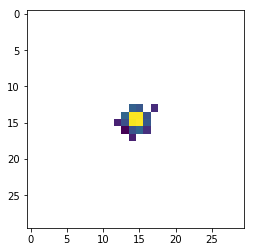

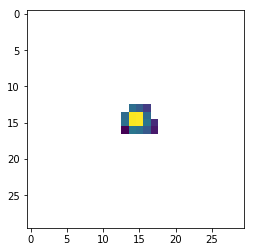

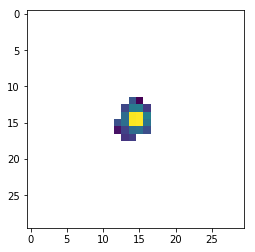

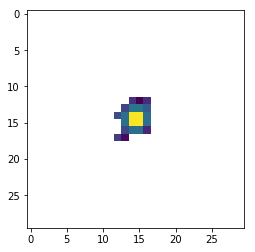

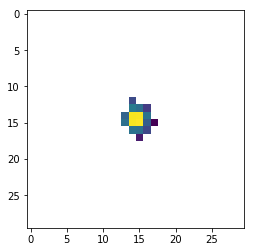

In [91]:
for im in or_data[:5]:
    plt.imshow(im)
    plt.show()

In [92]:
real_data = np.exp(or_data)
tanh_data = np.tanh(real_data)
real_data_mean = real_data.mean(axis=0)
real_data_std = real_data.std(axis=0)
#data = np.divide(real_data - real_data_mean, real_data_std, where= (real_data - real_data_mean) != 0)
data = tanh_data

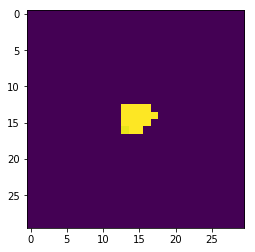

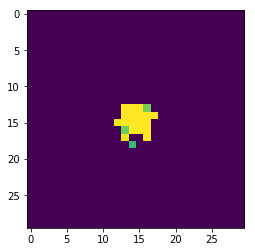

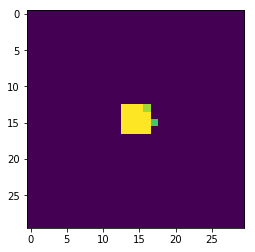

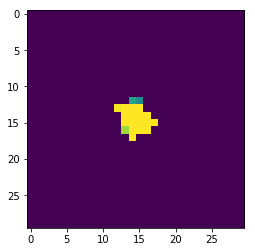

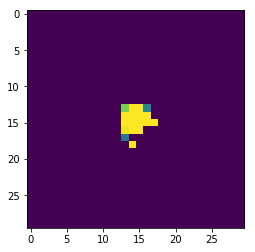

In [93]:
f = 10
for im in data[f:f+5]:
    plt.imshow(im)
    plt.show()

In [94]:
data[0].shape

(30, 30)

In [95]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(or_data[i][14][14]) +  np.exp(or_data[i][15][14]) + np.exp(or_data[i][14][15]) + np.exp(or_data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(or_data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(or_data[i][11+j][11+k])
                    


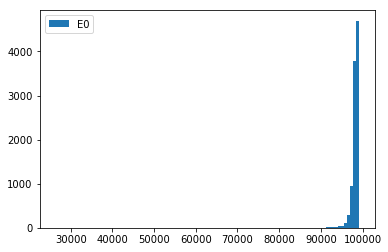

In [96]:
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()

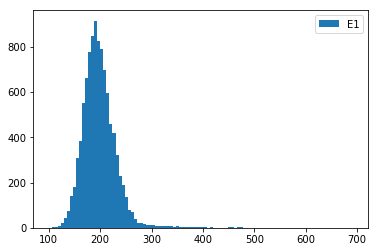

In [97]:
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()

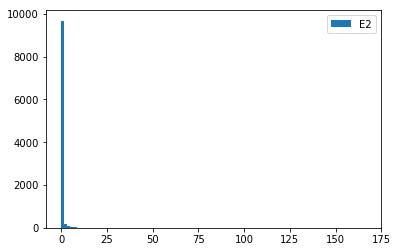

In [98]:
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

In [31]:
#L.AveragePooling2D?

In [32]:
def build_generator(noise_shape):
    generator = Sequential()
    
    generator.add(L.InputLayer(input_shape=[noise_shape]))
    generator.add(L.Dense(10 * 10))
    generator.add(L.Activation('relu'))
    generator.add(L.Reshape((10, 10, 1)))
    generator.add(L.Deconv2D(128 , kernel_size=5, activation='relu'))
    generator.add(L.Deconv2D(64, kernel_size=4))
    generator.add(L.Activation('relu'))
    generator.add(L.Deconv2D(64, kernel_size=4, activation='relu'))
    generator.add(L.Activation('relu'))
    generator.add(L.Deconv2D(32, kernel_size=3, activation='relu'))
    generator.add(L.Activation('relu'))
    generator.add(L.Deconv2D(32, kernel_size=3, activation='relu'))
    generator.add(L.Activation('relu'))
    generator.add(L.Deconv2D(16, kernel_size=3, activation='relu'))
    generator.add(L.Activation('relu'))
    generator.add(L.Deconv2D(16, kernel_size=3, activation='relu'))
    generator.add(L.Activation('relu'))
    generator.add(L.Deconv2D(1, kernel_size=3, activation='tanh'))
    
    return generator

def build_discriminator(img_shape):
    discriminator = Sequential()
    
    discriminator.add(L.InputLayer(img_shape))
    discriminator.add(L.Conv2D(32, kernel_size=4))
    discriminator.add(L.LeakyReLU())
    discriminator.add(L.Conv2D(32, kernel_size=4))
    discriminator.add(L.LeakyReLU())
    discriminator.add(L.AveragePooling2D(pool_size=2))
    discriminator.add(L.Conv2D(32, kernel_size=4))
    discriminator.add(L.LeakyReLU())
    discriminator.add(L.Conv2D(64, kernel_size=3))
    discriminator.add(L.LeakyReLU())
    discriminator.add(L.Conv2D(64, kernel_size=3))
    discriminator.add(L.LeakyReLU())
    discriminator.add(L.AveragePooling2D(pool_size=2))
    discriminator.add(L.Conv2D(128, kernel_size=1))
    discriminator.add(L.LeakyReLU())
    discriminator.add(L.Flatten())
    discriminator.add(L.Dense(256))
    discriminator.add(L.Activation('tanh'))
    discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    
    return discriminator

In [33]:
def build_gan(disc_learn_rate = 1e-3, gen_learn_rate = 1e-2, noise_size = 100, image_size = (30, 30, 1)):
    gen = build_generator(noise_size)
    disc = build_discriminator(image_size)
    
    real_img = tf.placeholder(tf.float32,[None,]+ list(image_size))
    noise = tf.placeholder(tf.float32,[None, noise_size])
    
    gen_img = gen(noise)
    disc_on_real_data = disc(real_img)
    disc_on_gen_data = disc(gen_img)
    
    IS_REAL = 1
    IS_FAKE = 0
    
    disc_loss = -tf.reduce_mean(disc_on_real_data[:, IS_REAL] + 
                                disc_on_gen_data[:, IS_FAKE])
    disc_loss += tf.reduce_mean(np.abs(disc.layers[-1].kernel))
    
    gen_loss = -tf.reduce_mean(disc_on_gen_data[:, IS_REAL])
    
    train_gen = tf.train.AdamOptimizer(learning_rate=gen_learn_rate, beta1=0.5, beta2=0.9) \
                                        .minimize(gen_loss, var_list = gen.trainable_weights)
    train_disc = tf.train.AdamOptimizer(learning_rate=disc_learn_rate, beta1=0.5, beta2=0.9) \
                                        .minimize(disc_loss, var_list = disc.trainable_weights)
    return disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise

In [34]:
def random_noise(a):
    noise = np.random.normal(size=(a, noise_size)).astype('float32')
    return noise

def random_data(bsize):
    ind = np.random.choice(np.arange(data.shape[0]), size=bsize)
    r_data = data[ind].reshape((-1, 30, 30, 1))
    return r_data

def sample_images(nrow, ncol):
    images = gen.predict(random_noise(nrow * ncol ))
    if np.var(images)!= 0:
        images = images.clip(np.min(data), np.max(data))
    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(images[i].reshape(30, 30))
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(disc.predict(random_data(bsize)))[:,1],
             label='D(x)', bins=100, alpha=0.5,range=[0,1])
    predict_on_generated = (np.exp(disc.predict(gen.predict(random_noise(1000))))[:,1])
    plt.hist(predict_on_generated, label='D(G(z))', bins=100, alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()
    return predict_on_generated.mean()

In [35]:
def play_the_game(k_disc, k_gen, disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, \
                                          noise, show_each = 100, check_each = 100, epochs = 100000):
    sess = tf.InteractiveSession(config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth = True)))
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        feed_dict = {
            real_img:random_data(100), 
            noise:random_noise(100)
        }
        
        for _ in range(k_disc):
            sess.run(train_disc, feed_dict)
        for _ in range(k_gen):
            sess.run(train_gen, feed_dict)
        
        if epoch % show_each==0:
            print("epoch", epoch)
            sample_images(1, 2)
            sample_images(1, 2)
        if epoch % check_each==0:
            if epoch % show_each != 0:
                print("epoch", epoch)
            discriminator_to_generator_trust = sample_probas(1000)
            if discriminator_to_generator_trust < 0.05:
                print("Generator lost the game around the epoch = ", epoch)
                return epoch
    return -1

epoch 0


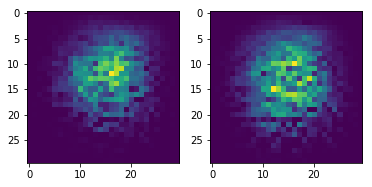

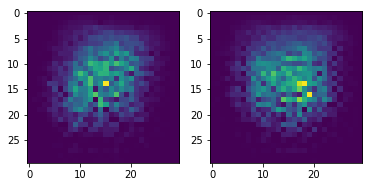

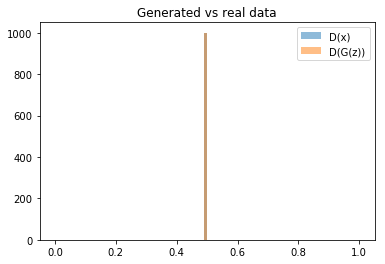

epoch 50


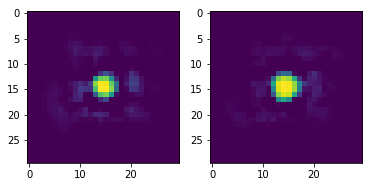

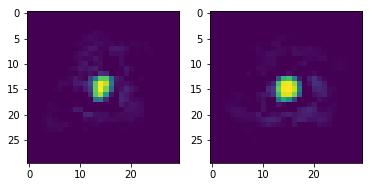

epoch 100


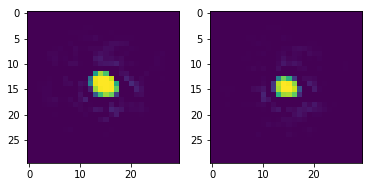

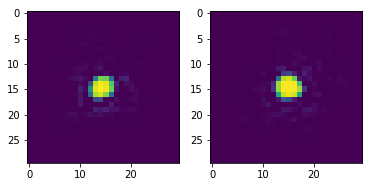

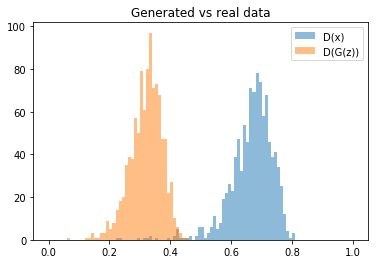

epoch 150


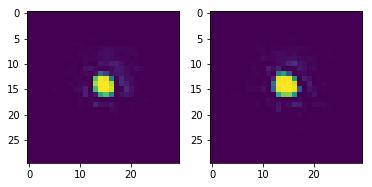

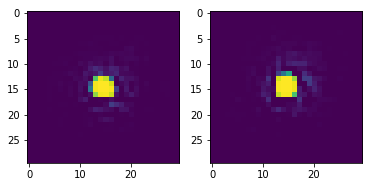

epoch 200


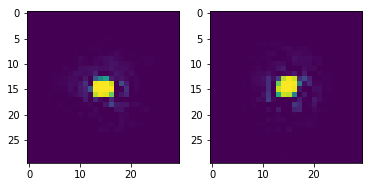

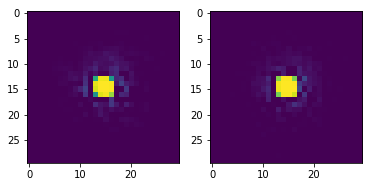

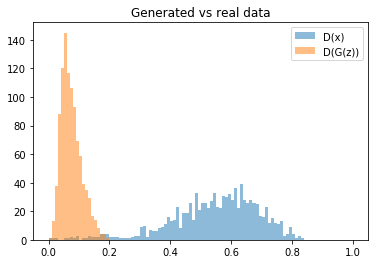

epoch 250


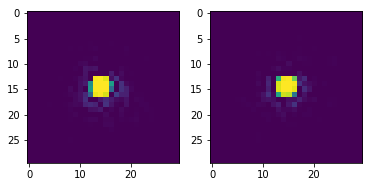

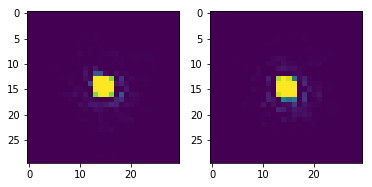

epoch 300


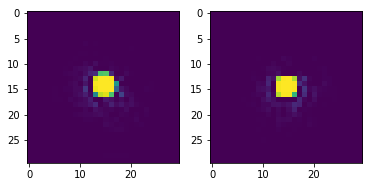

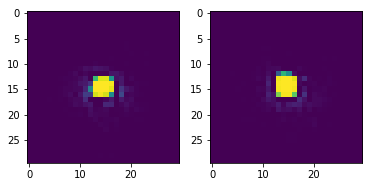

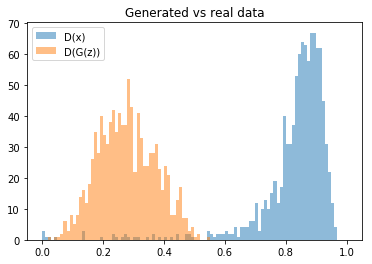

epoch 350


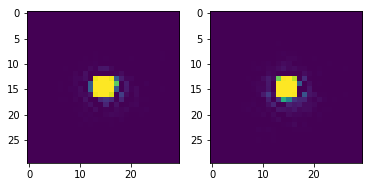

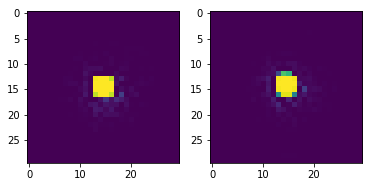

epoch 400


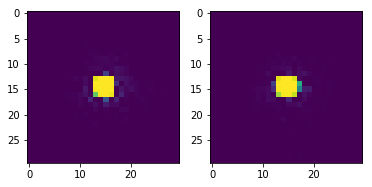

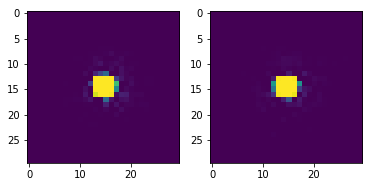

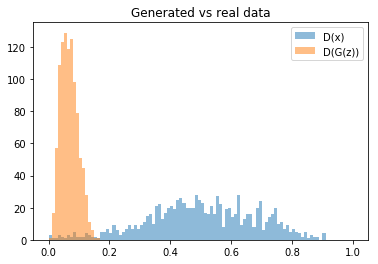

epoch 450


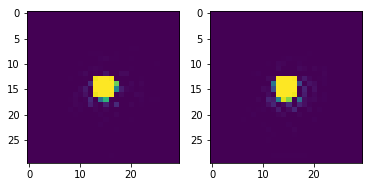

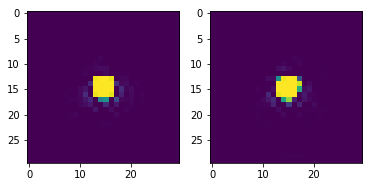

epoch 500


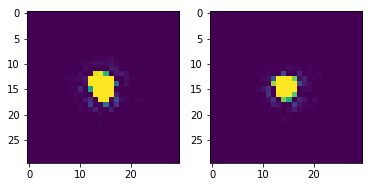

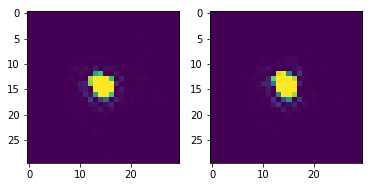

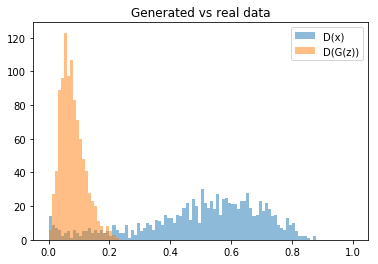

epoch 550


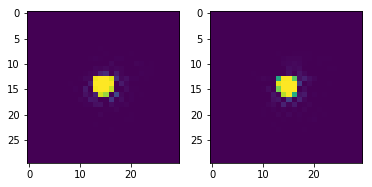

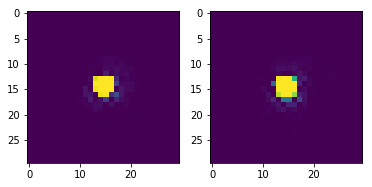

epoch 600


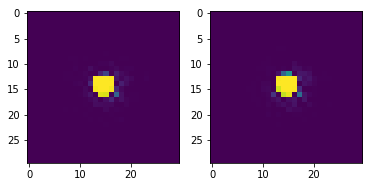

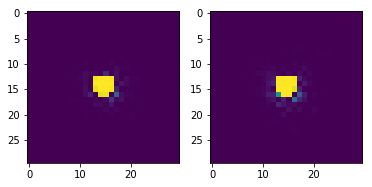

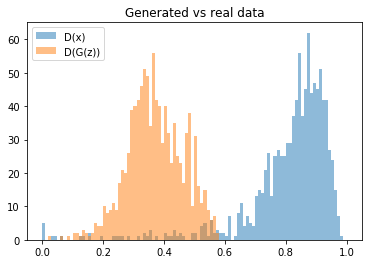

epoch 650


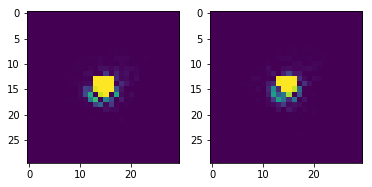

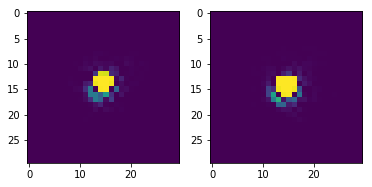

epoch 700


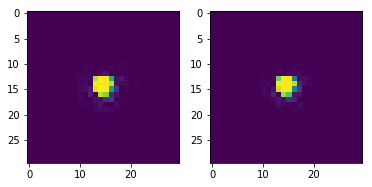

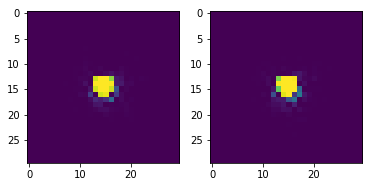

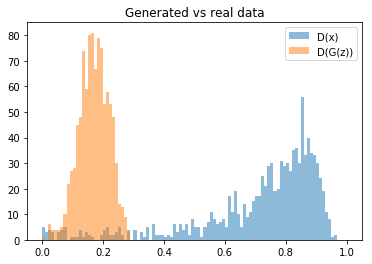

epoch 750


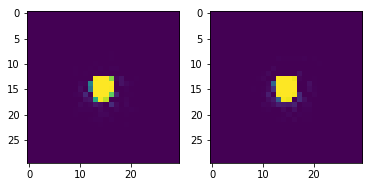

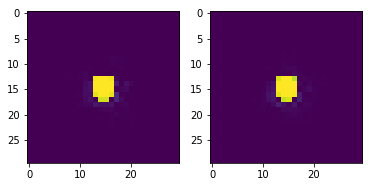

epoch 800


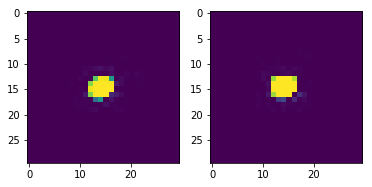

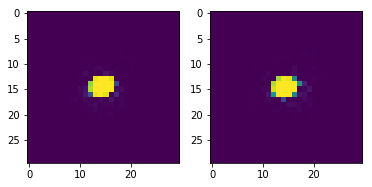

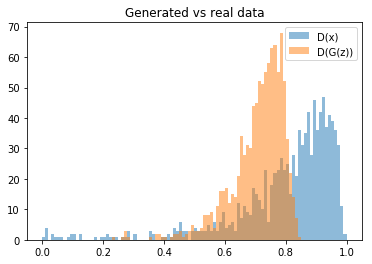

epoch 850


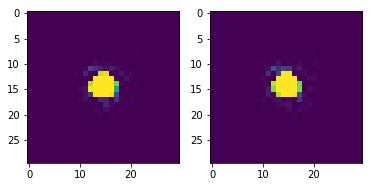

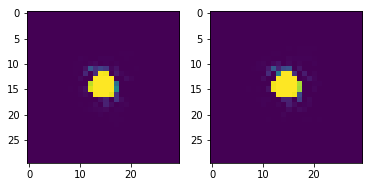

epoch 900


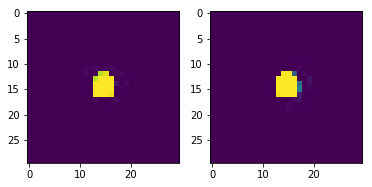

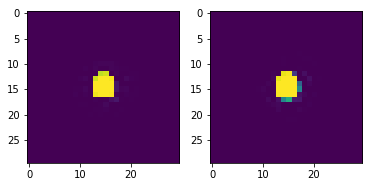

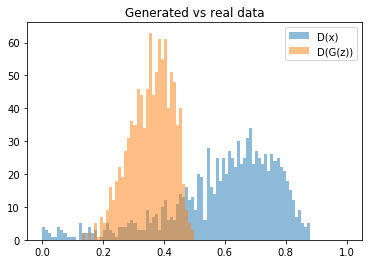

epoch 950


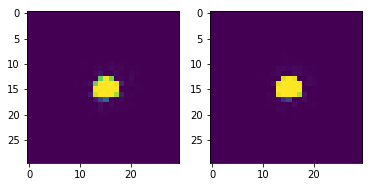

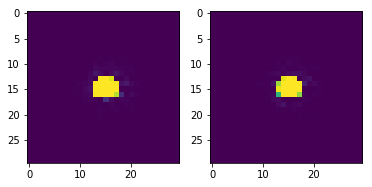

epoch 1000


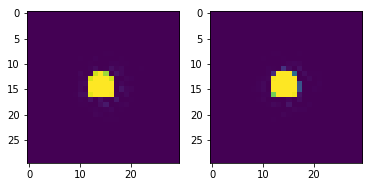

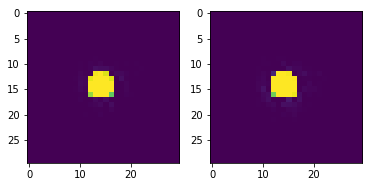

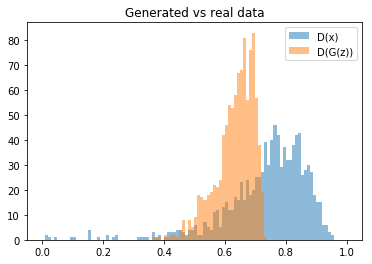

epoch 1050


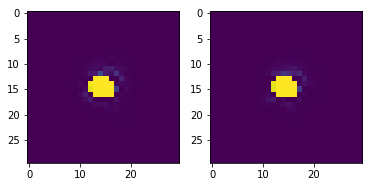

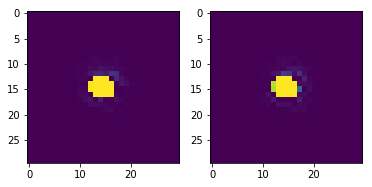

epoch 1100


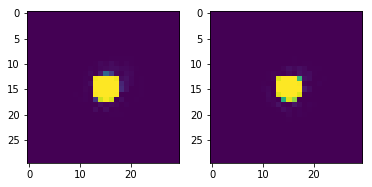

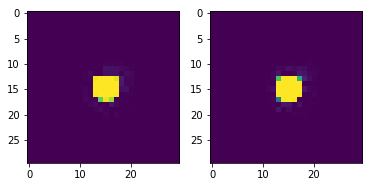

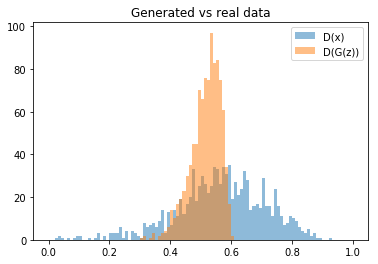

epoch 1150


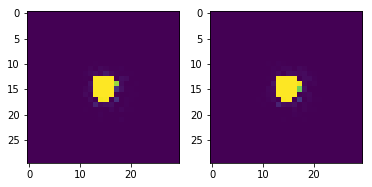

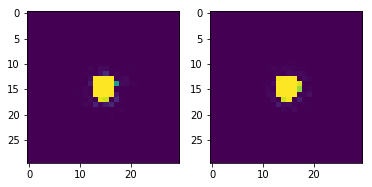

epoch 1200


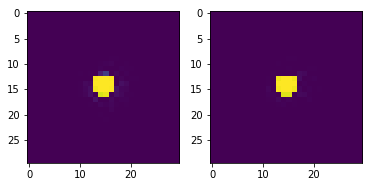

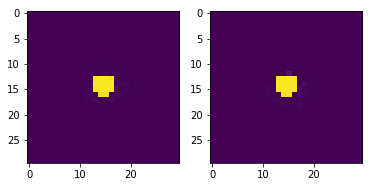

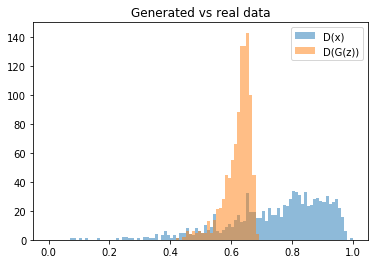

epoch 1250


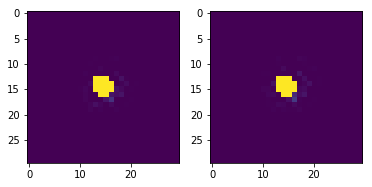

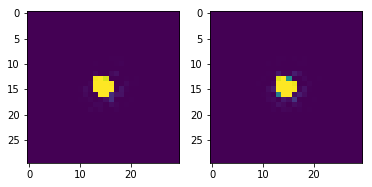

epoch 1300


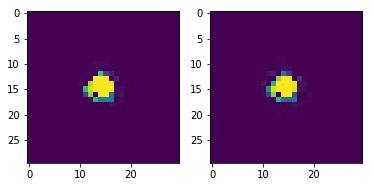

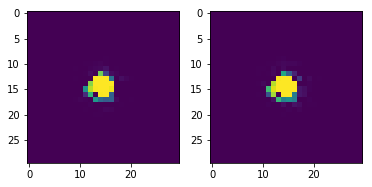

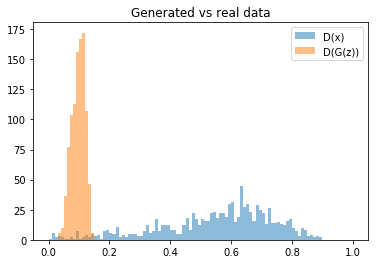

epoch 1350


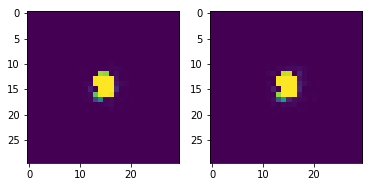

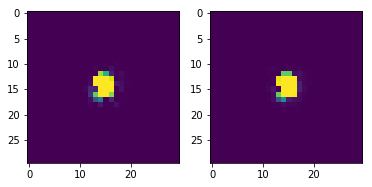

epoch 1400


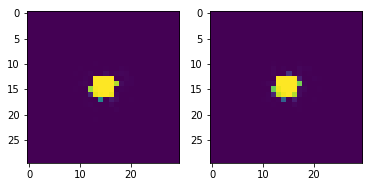

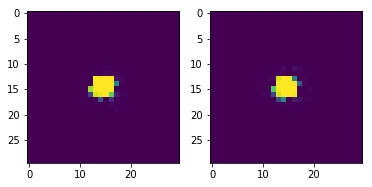

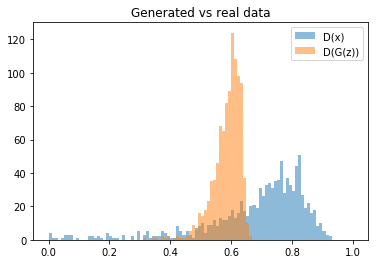

epoch 1450


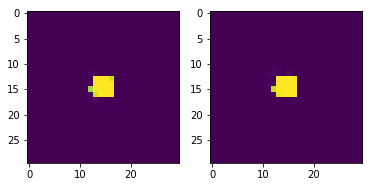

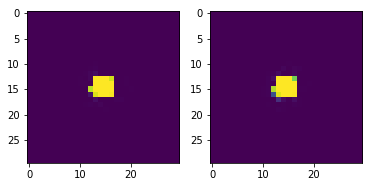

epoch 1500


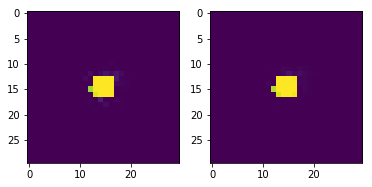

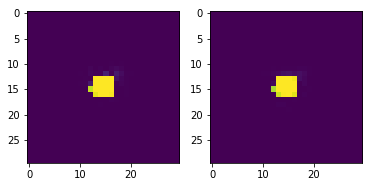

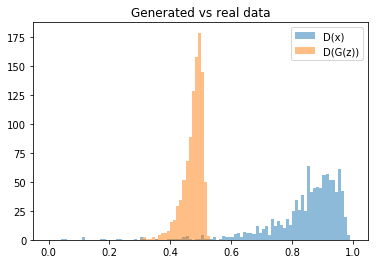

epoch 1550


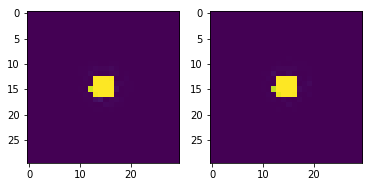

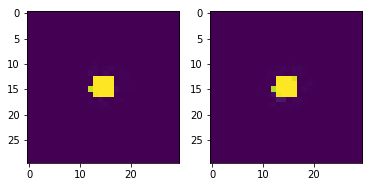

epoch 1600


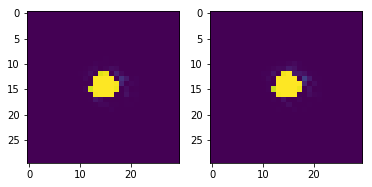

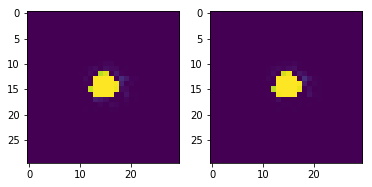

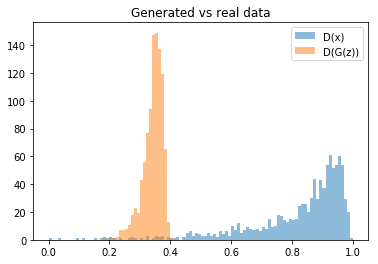

epoch 1650


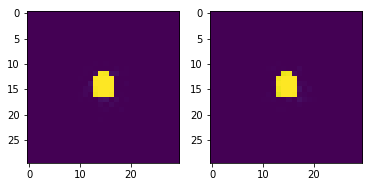

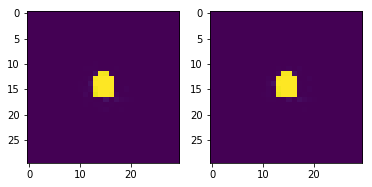

epoch 1700


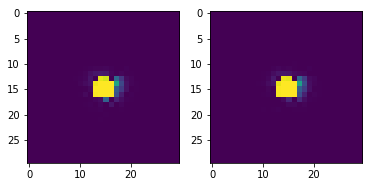

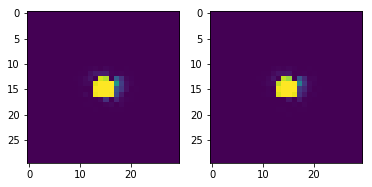

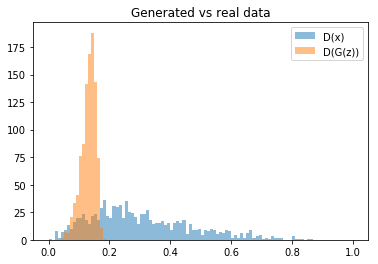

epoch 1750


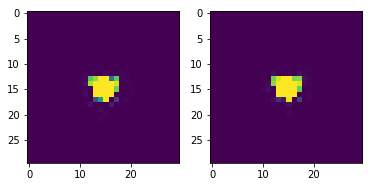

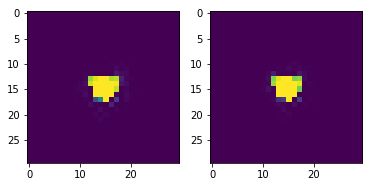

epoch 1800


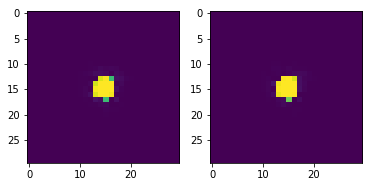

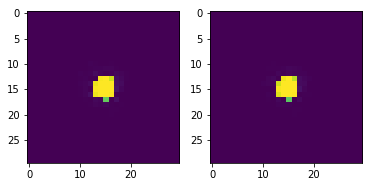

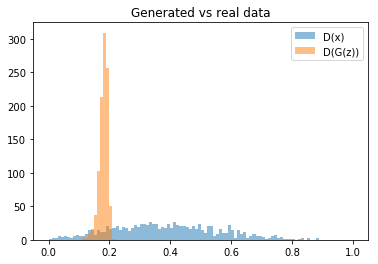

epoch 1850


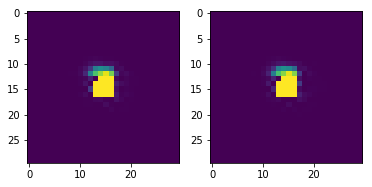

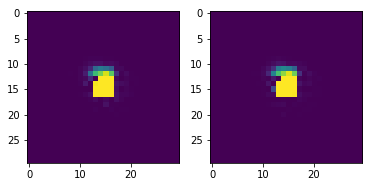

epoch 1900


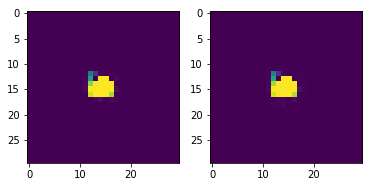

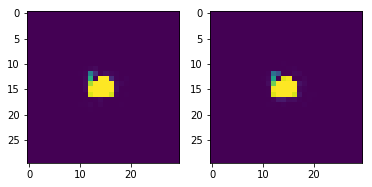

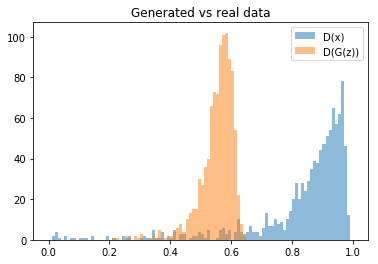

epoch 1950


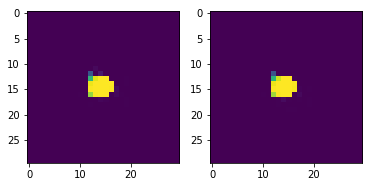

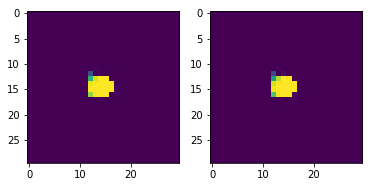

epoch 2000


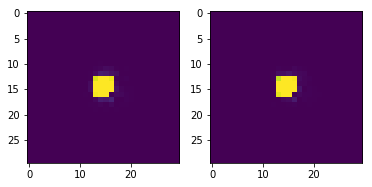

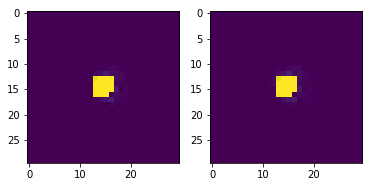

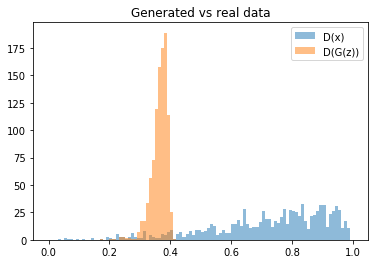

epoch 2050


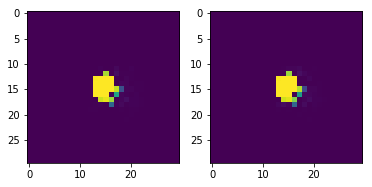

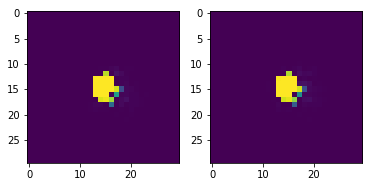

epoch 2100


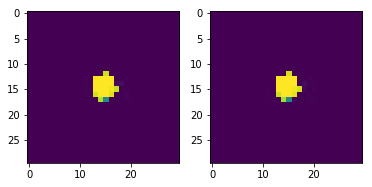

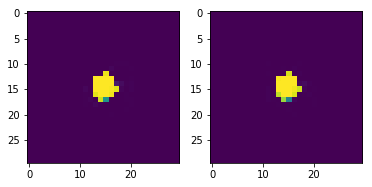

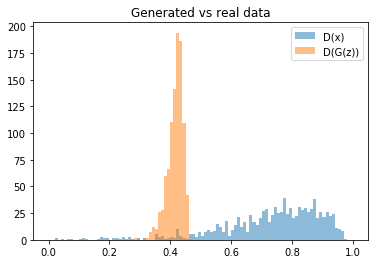

epoch 2150


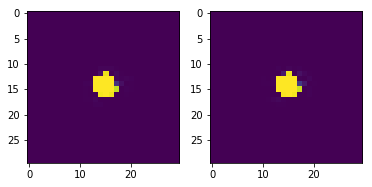

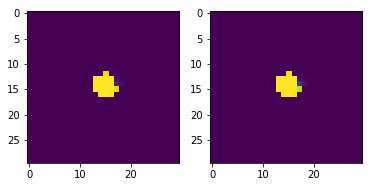

epoch 2200


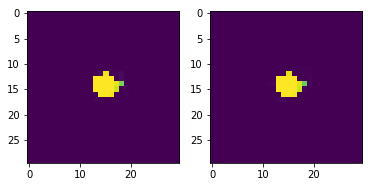

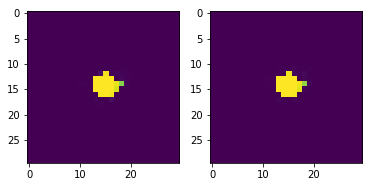

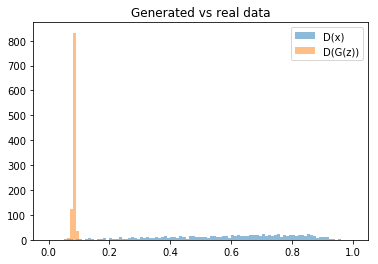

epoch 2250


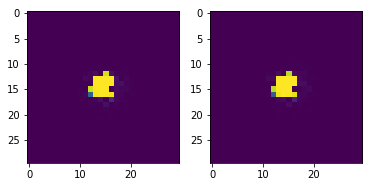

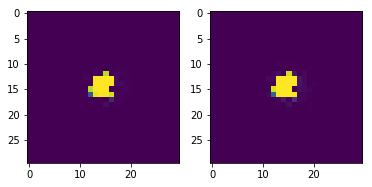

epoch 2300


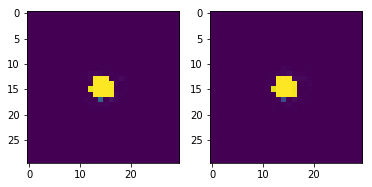

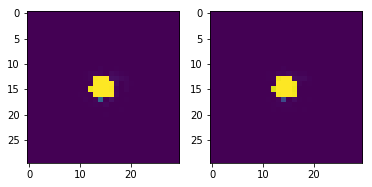

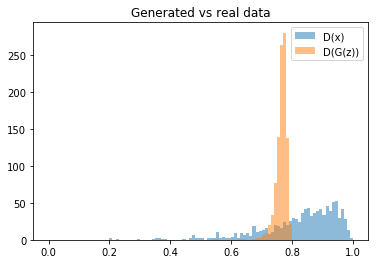

epoch 2350


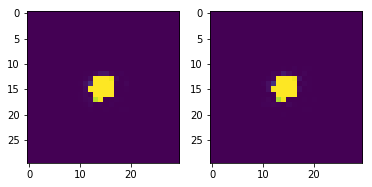

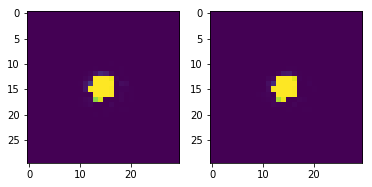

epoch 2400


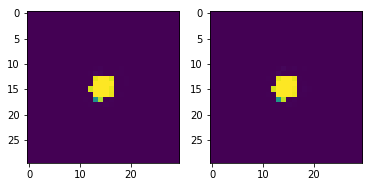

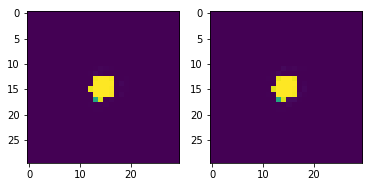

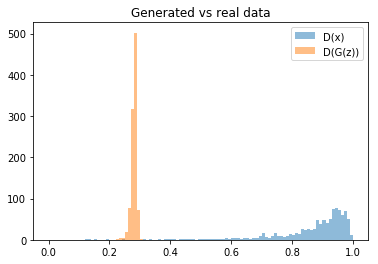

epoch 2450


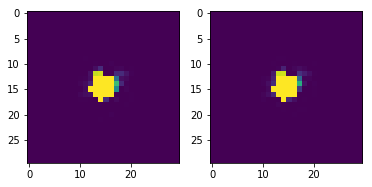

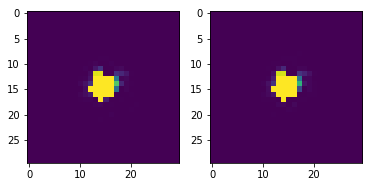

epoch 2500


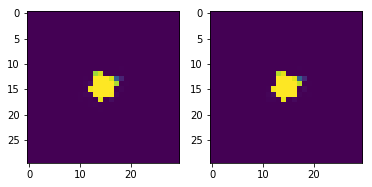

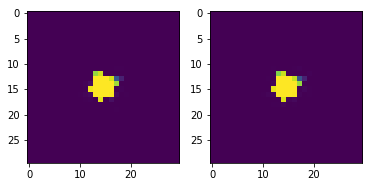

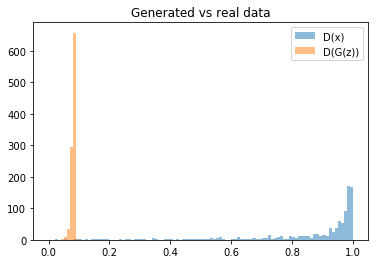

epoch 2550


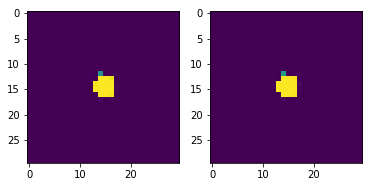

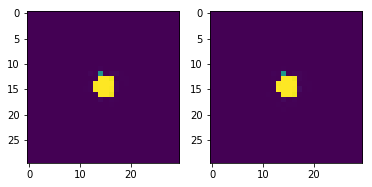

epoch 2600


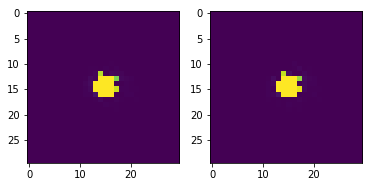

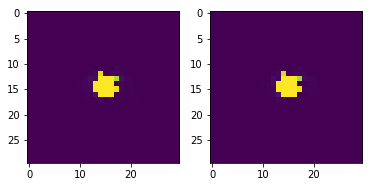

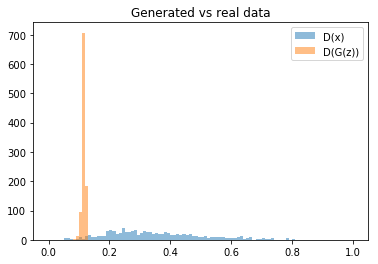

epoch 2650


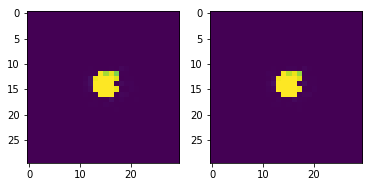

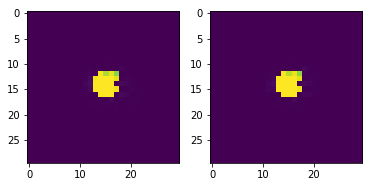

epoch 2700


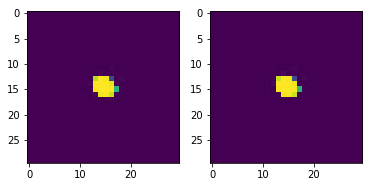

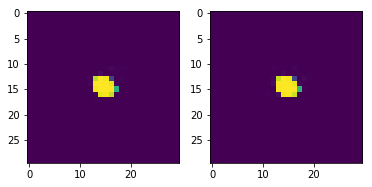

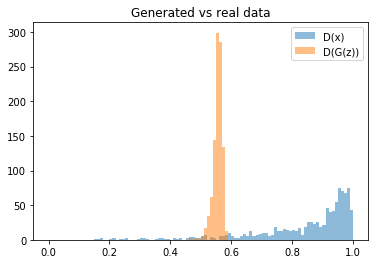

epoch 2750


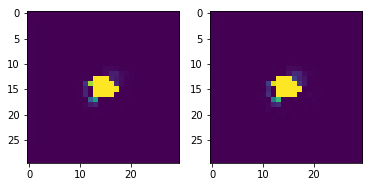

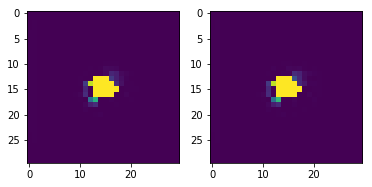

epoch 2800


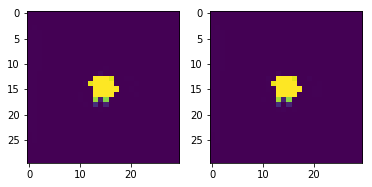

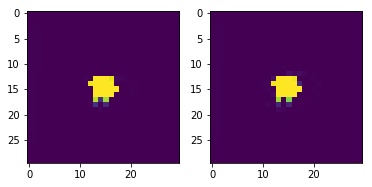

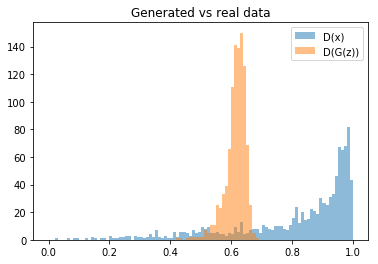

epoch 2850


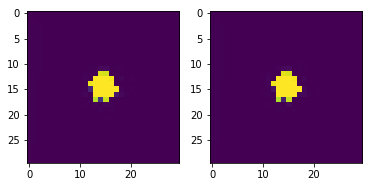

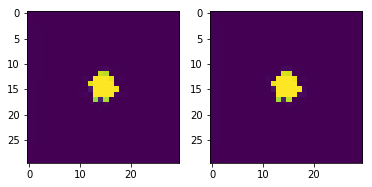

epoch 2900


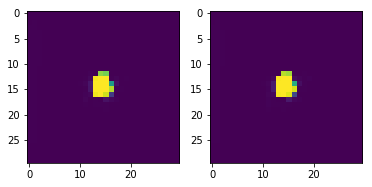

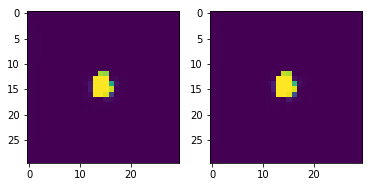

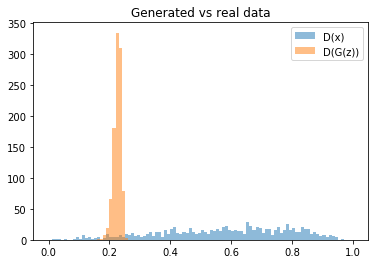

epoch 2950


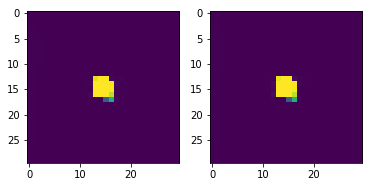

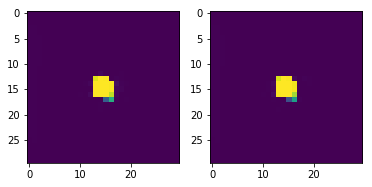

epoch 3000


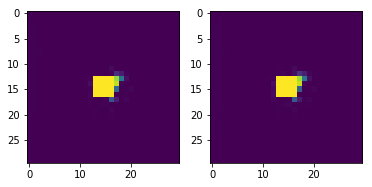

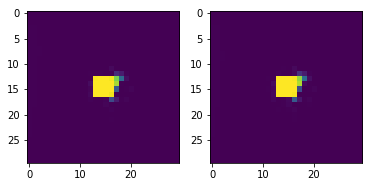

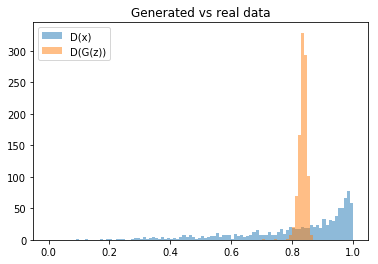

epoch 3050


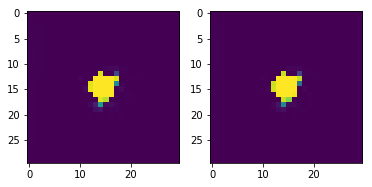

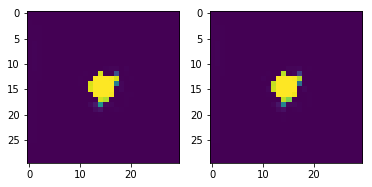

epoch 3100


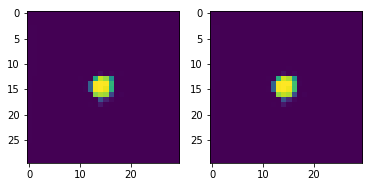

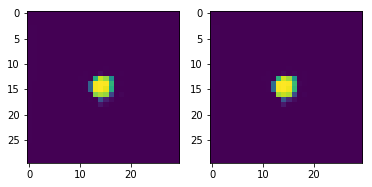

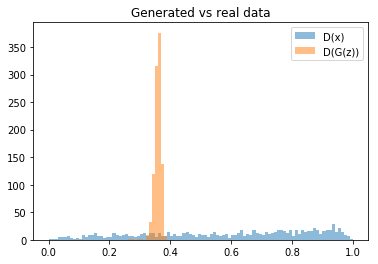

epoch 3150


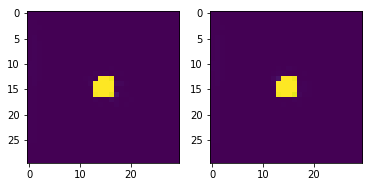

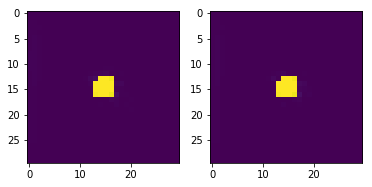

epoch 3200


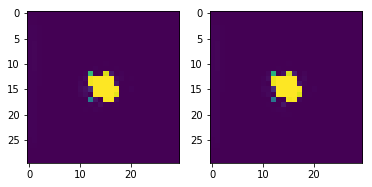

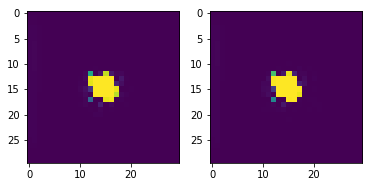

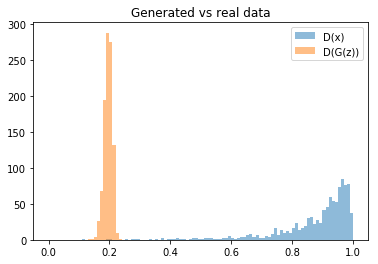

epoch 3250


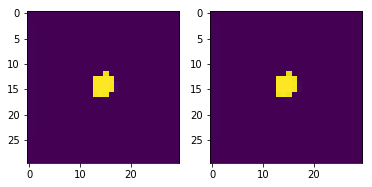

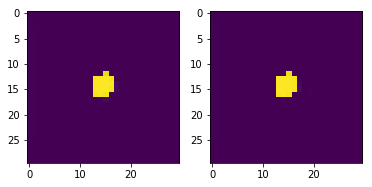

epoch 3300


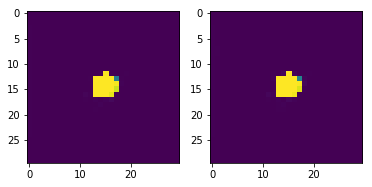

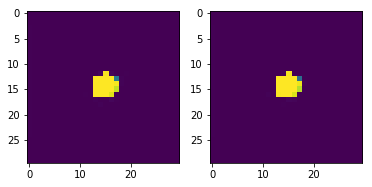

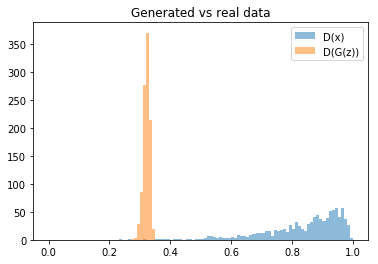

epoch 3350


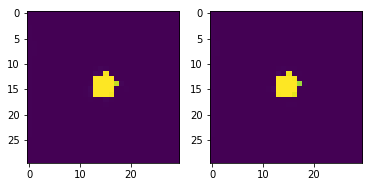

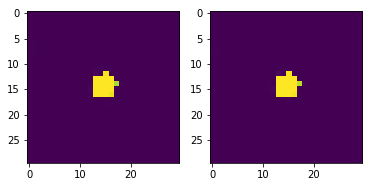

epoch 3400


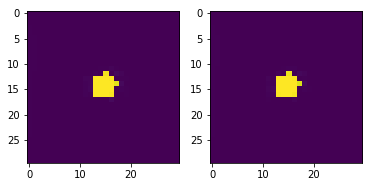

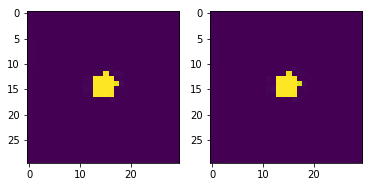

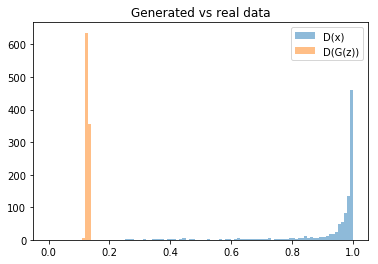

epoch 3450


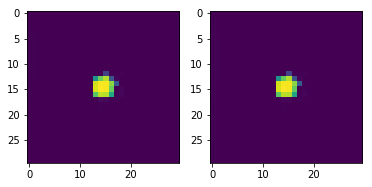

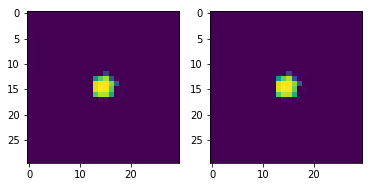

epoch 3500


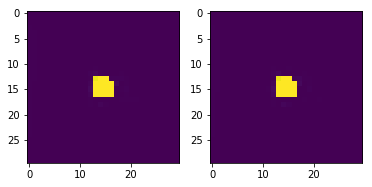

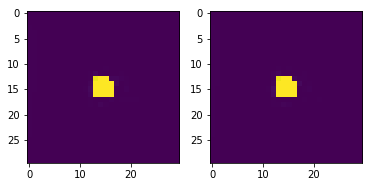

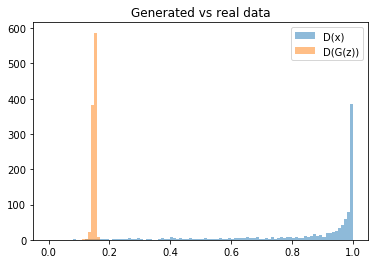

epoch 3550


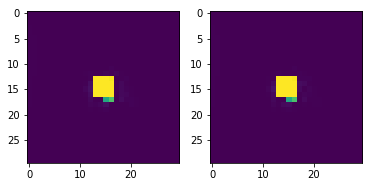

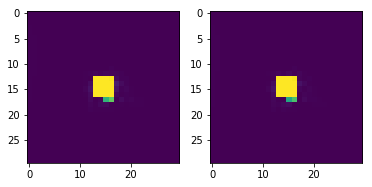

epoch 3600


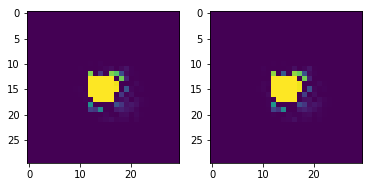

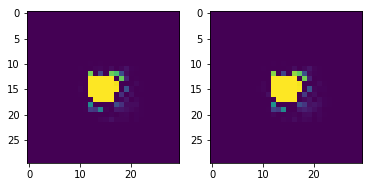

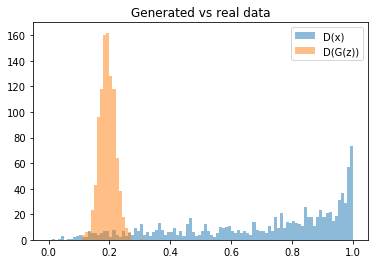

epoch 3650


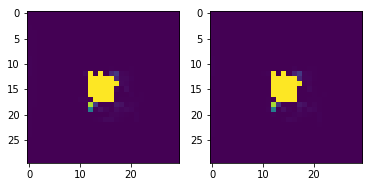

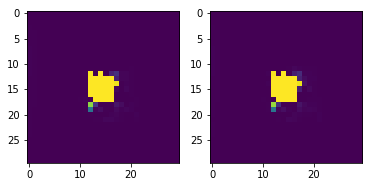

epoch 3700


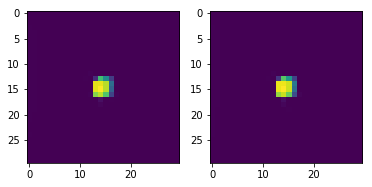

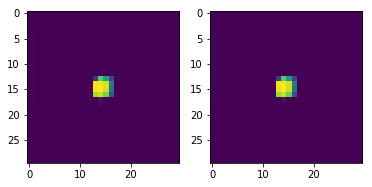

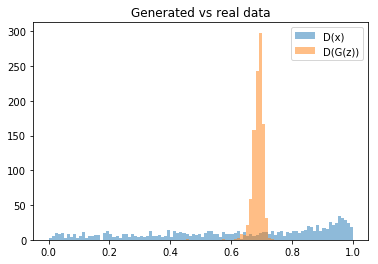

epoch 3750


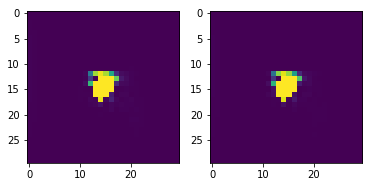

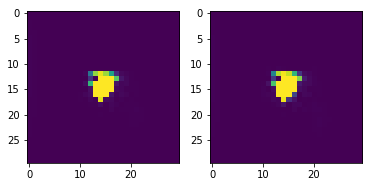

epoch 3800


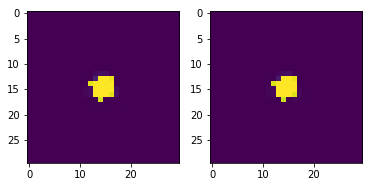

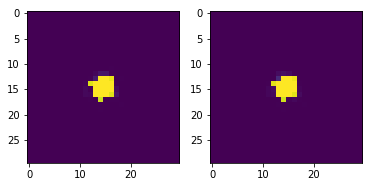

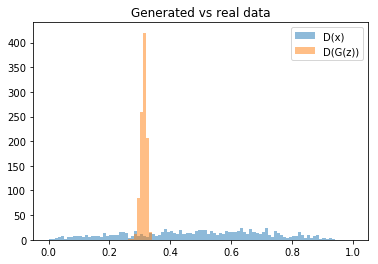

epoch 3850


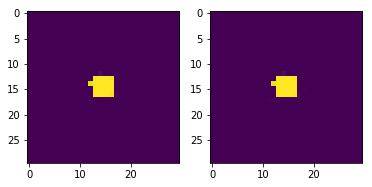

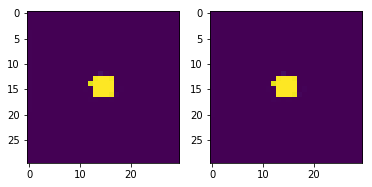

epoch 3900


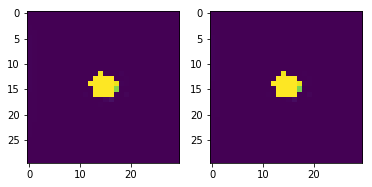

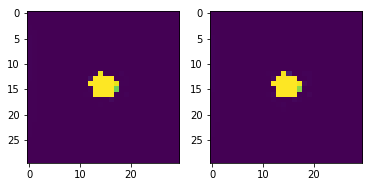

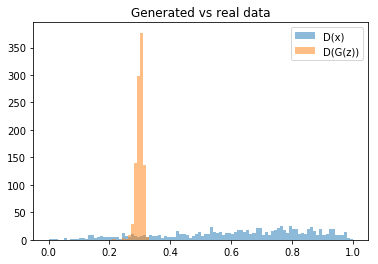

epoch 3950


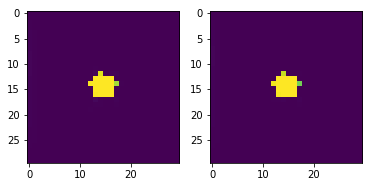

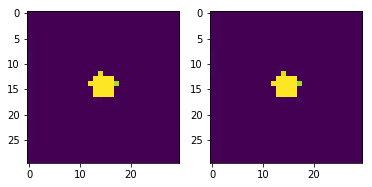

epoch 4000


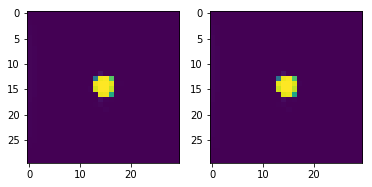

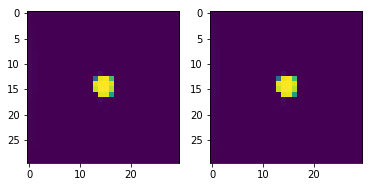

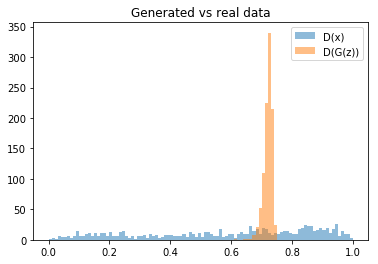

epoch 4050


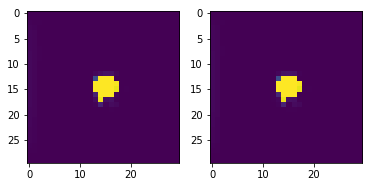

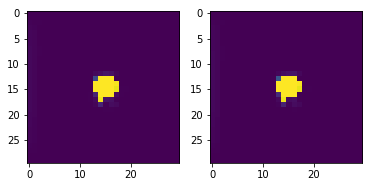

epoch 4100


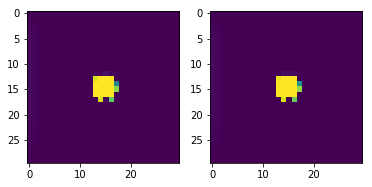

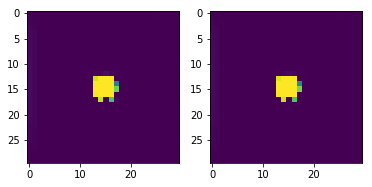

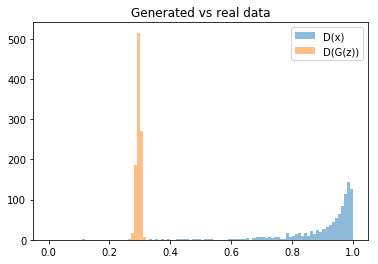

epoch 4150


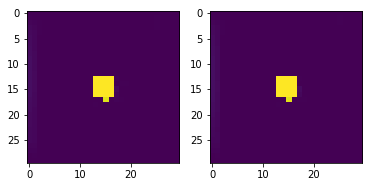

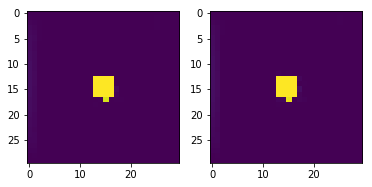

epoch 4200


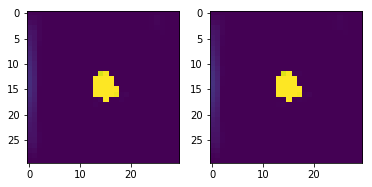

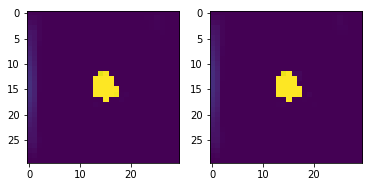

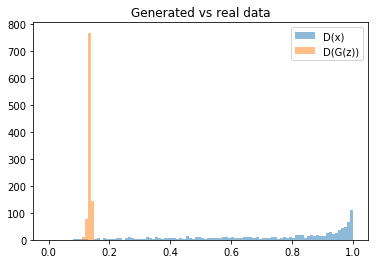

epoch 4250


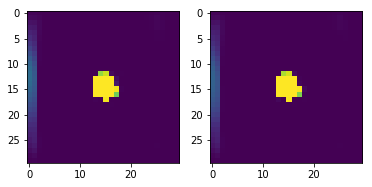

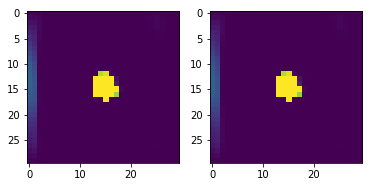

epoch 4300


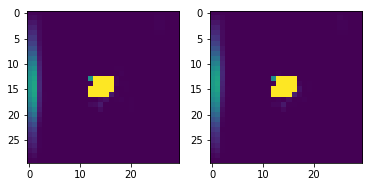

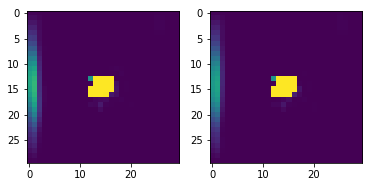

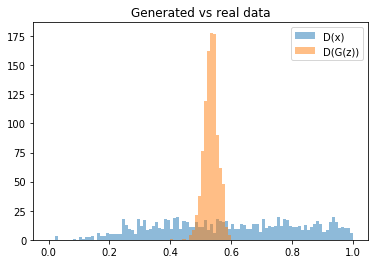

epoch 4350


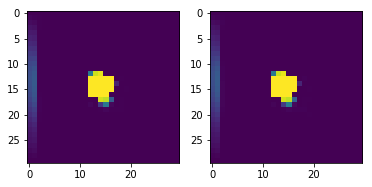

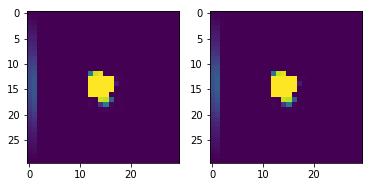

epoch 4400


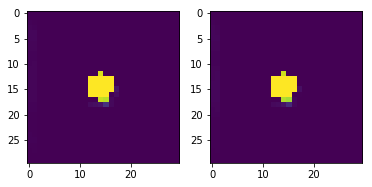

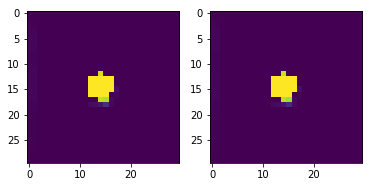

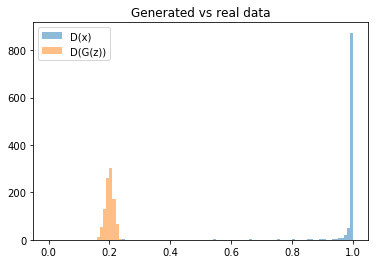

epoch 4450


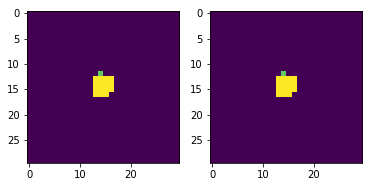

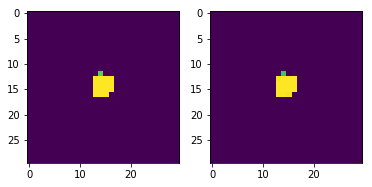

epoch 4500


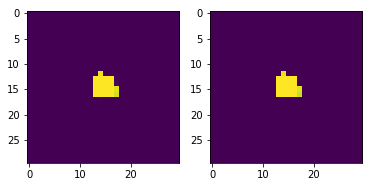

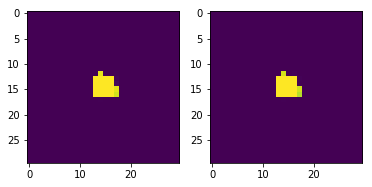

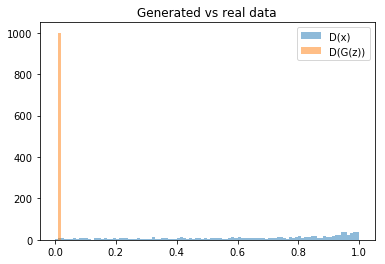

Generator lost the game around the epoch =  4500


In [36]:
k_disc = 1  # число обучений дискриминатора за эпоху
k_gen = 3  # число обучений генератора за эпоху
disc_learn_rate = 1e-4  # скорость обучения дискриминатора
gen_learn_rate = 1e-4  #скорость обучения генератора
epochs = 30000  # максимальное число эпох обучения
noise_size = 100
image_size = (30, 30, 1)
show_each = 50  # показывать каждую эпоху кратную ...
check_each = 100  # сравнивать работу дискриминатора на реальных и сгенерированных данных каждую эпоху кратную ...
disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise = \
                            build_gan(disc_learn_rate, gen_learn_rate, noise_size, image_size)
%matplotlib inline
generator_lost_on_epoch = play_the_game(k_disc, k_gen, disc, gen, \
                            disc_loss, gen_loss, train_disc, train_gen, real_img, noise, show_each, check_each, epochs)

In [37]:
def sample_x_images(size):
    images = gen.predict(random_noise(size)).reshape(-1,30,30)
    return images

In [41]:
def show_the_rezults():
    images = sample_x_images(1000)
    exp_images = np.arctanh(images)
    # exp_data = np.exp(or_data)
    # real_images = exp_images * exp_data.std(axis=0) + exp_data.mean(axis=0)
    real_images = exp_images
    
    central_2 = np.sum(real_images[:, 14:16, 14:16], axis=(1, 2))

    mask_4_2 = np.zeros((30, 30), dtype=bool)
    mask_4_2[13:17, [13, 16]] = True
    mask_4_2[[13, 16], 13:17] = True
    
    central_4_2 = np.sum(real_images[:, mask_4_2], axis=1)
    
    mask_6_4 = np.zeros((30, 30), dtype=bool)
    mask_6_4[12:18, [12, 17]] = True
    mask_6_4[[12, 17], 12:18] = True
    
    central_6_4 = np.sum(real_images[:, mask_6_4], axis=1)
    
    plt.figure(figsize=(12,6))
    plt.title('E1')
    plt.hist([central_4_2, E_first], bins=100, label=['sample', 'real'], range=(0, 400))
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.title('E2')
    plt.hist([central_6_4, E_second], bins=100, label=['sample', 'real'], range=(0, 30))
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title('E1')
    plt.hist([central_2, E], bins=100, label=['sample', 'real'], range=(90000, 100000))
    plt.legend(loc='best')
    plt.show()


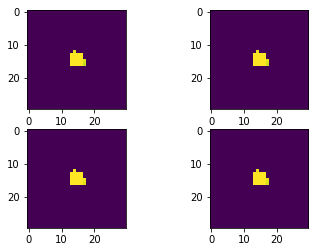

In [58]:
sample_images(2, 2)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


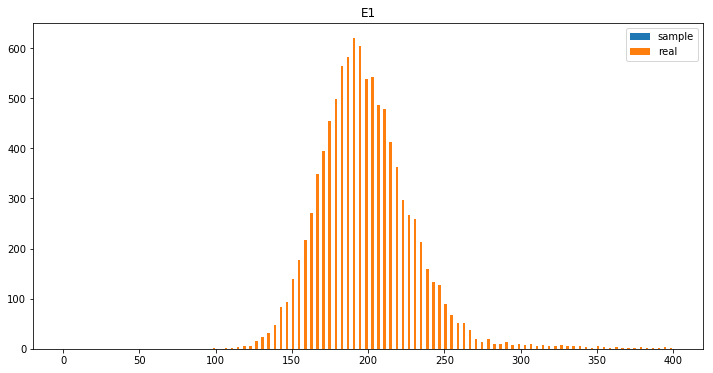

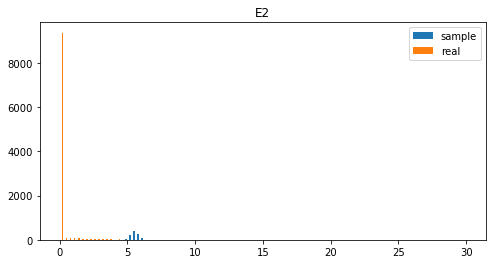

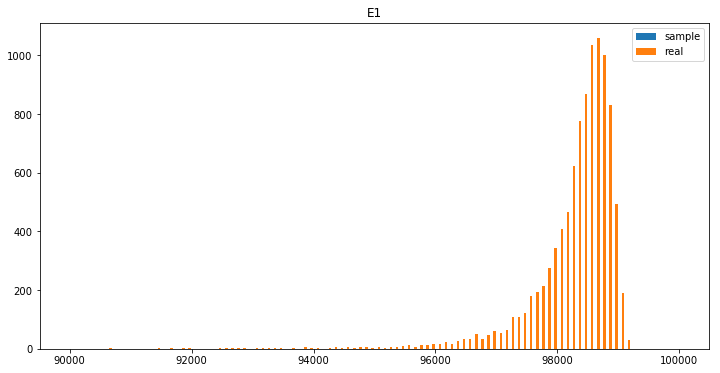

In [43]:
show_the_rezults()

In [51]:
rez_data = sample_x_images(1000)
rez2_data = np.arctanh(rez_data)
or2_data = np.exp(or_data)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in arctanh
  


In [71]:
a = np.array([0, or_data[0][0][0], 100, -or_data[0][0][0]])
print(a)

[   0.  -inf  100.   inf]


In [72]:
b = np.tanh(a)
print(b)

[ 0. -1.  1.  1.]


In [73]:
c = np.arctanh(b)
print(c)

[  0. -inf  inf  inf]


/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in arctanh
  """Entry point for launching an IPython kernel.


In [76]:
images = sample_x_images(1000)
real_images = np.arctanh(images)

central_2 = np.sum(real_images[:, 14:16, 14:16], axis=(1, 2))

mask_4_2 = np.zeros((30, 30), dtype=bool)
mask_4_2[13:17, [13, 16]] = True
mask_4_2[[13, 16], 13:17] = True
    
central_4_2 = np.sum(real_images[:, mask_4_2], axis=1)
    
mask_6_4 = np.zeros((30, 30), dtype=bool)
mask_6_4[12:18, [12, 17]] = True
mask_6_4[[12, 17], 12:18] = True
    
central_6_4 = np.sum(real_images[:, mask_6_4], axis=1)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in arctanh
  


In [80]:
real_images[0]

array([[ -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05],
       [ -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
         -2.77120926e-05,  -2.77120926e-05,  -2.77120926e-05,
       

epoch 0


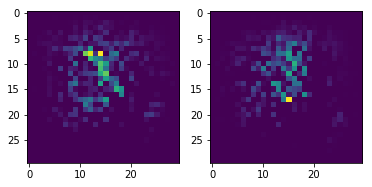

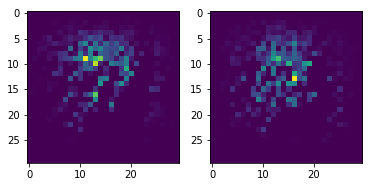

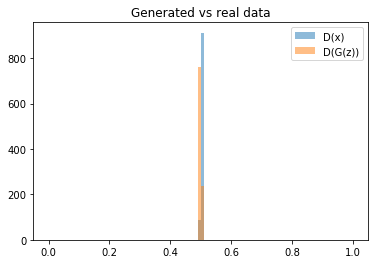

epoch 50


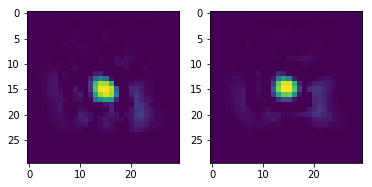

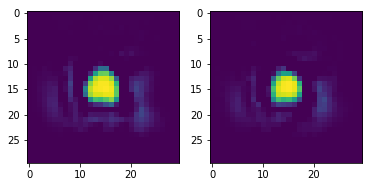

epoch 100


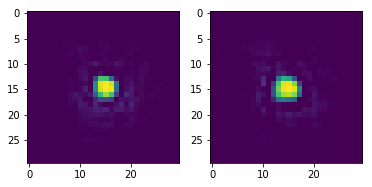

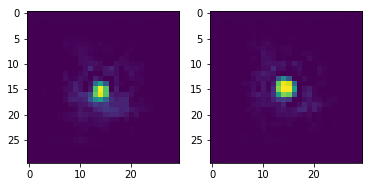

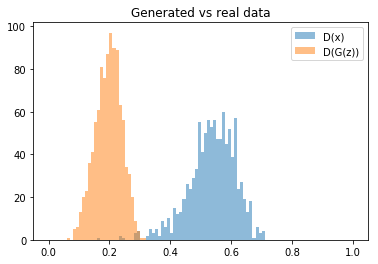

epoch 150


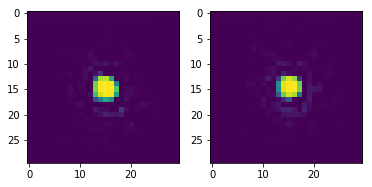

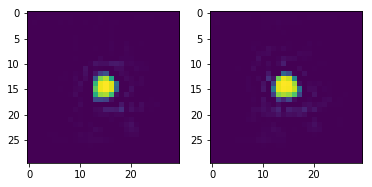

epoch 200


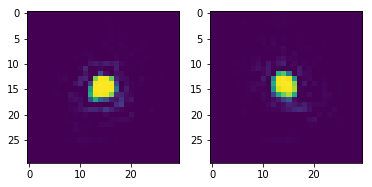

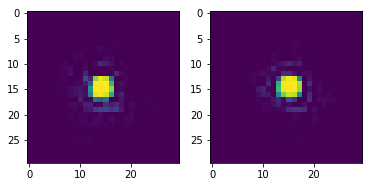

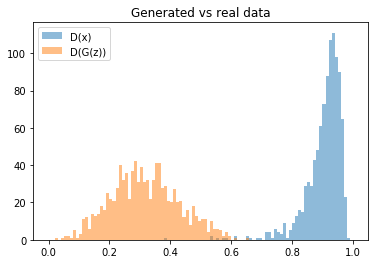

epoch 250


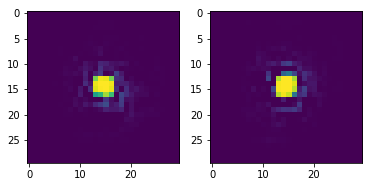

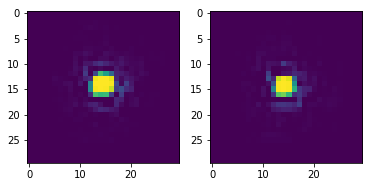

epoch 300


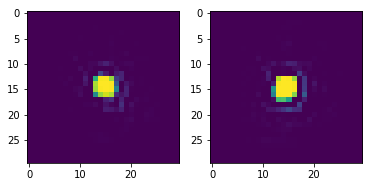

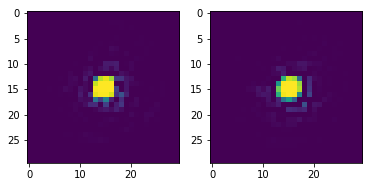

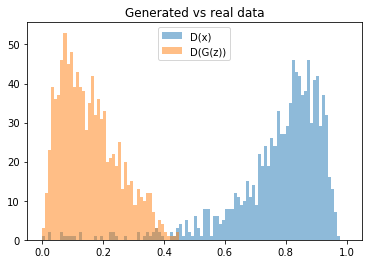

epoch 350


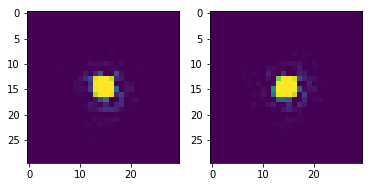

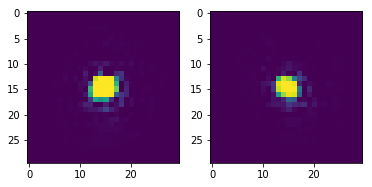

epoch 400


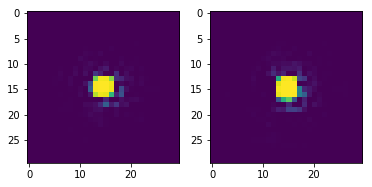

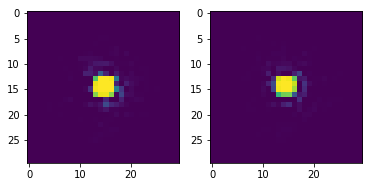

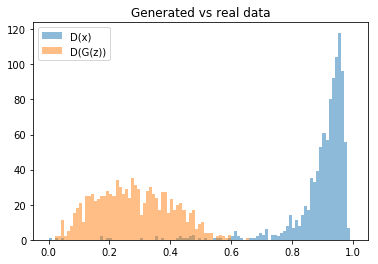

epoch 450


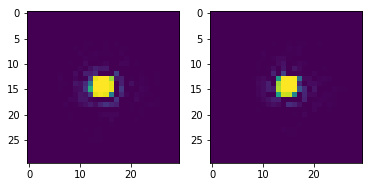

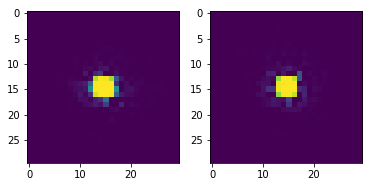

epoch 500


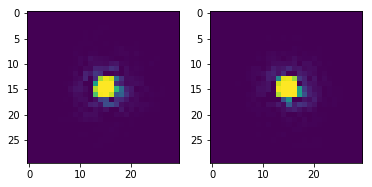

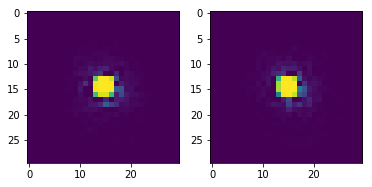

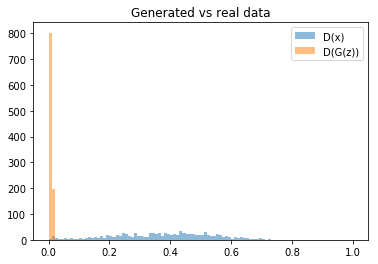

Generator lost the game around the epoch =  500


In [81]:
k_disc = 1  # число обучений дискриминатора за эпоху
k_gen = 2  # число обучений генератора за эпоху
disc_learn_rate = 1e-4  # скорость обучения дискриминатора
gen_learn_rate = 1e-4  #скорость обучения генератора
epochs = 30000  # максимальное число эпох обучения
noise_size = 100
image_size = (30, 30, 1)
show_each = 50  # показывать каждую эпоху кратную ...
check_each = 100  # сравнивать работу дискриминатора на реальных и сгенерированных данных каждую эпоху кратную ...
disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise = \
                            build_gan(disc_learn_rate, gen_learn_rate, noise_size, image_size)
%matplotlib inline
generator_lost_on_epoch = play_the_game(k_disc, k_gen, disc, gen, \
                            disc_loss, gen_loss, train_disc, train_gen, real_img, noise, show_each, check_each, epochs)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


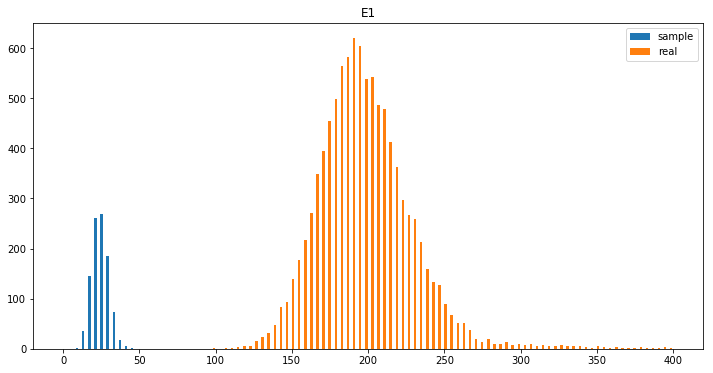

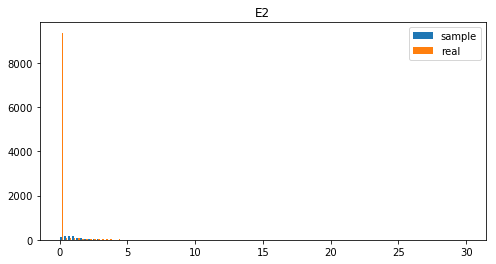

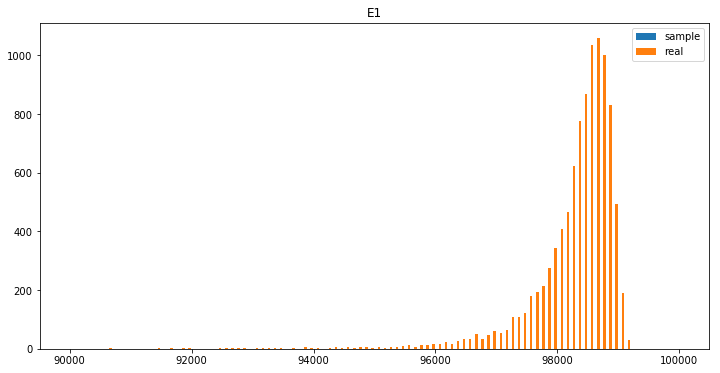

In [82]:
show_the_rezults()

epoch 0


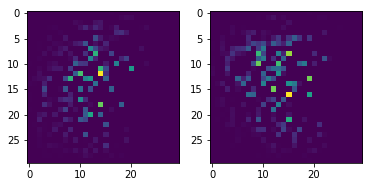

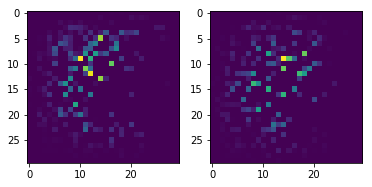

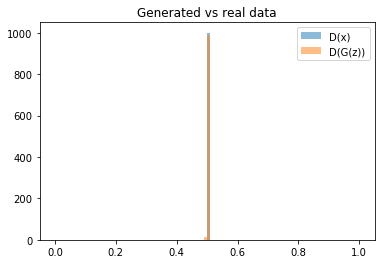

epoch 50


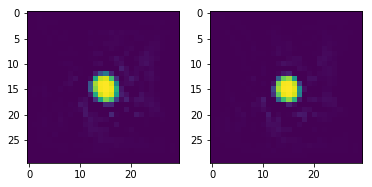

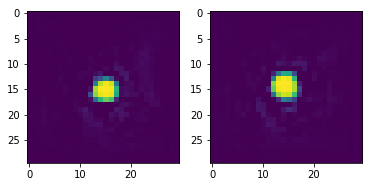

epoch 100


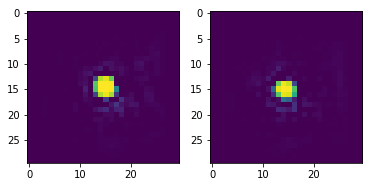

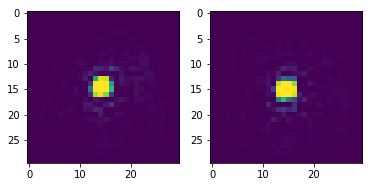

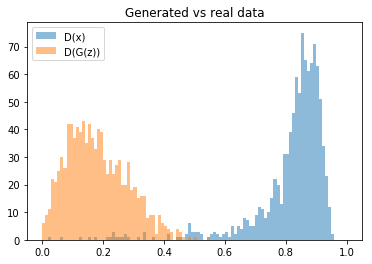

epoch 150


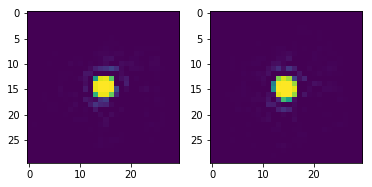

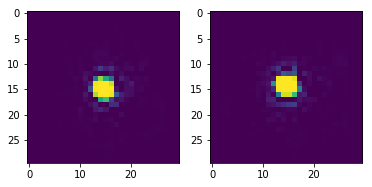

epoch 200


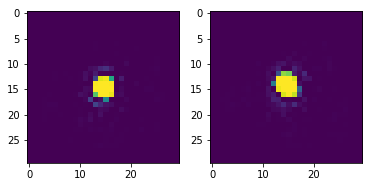

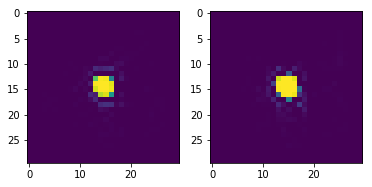

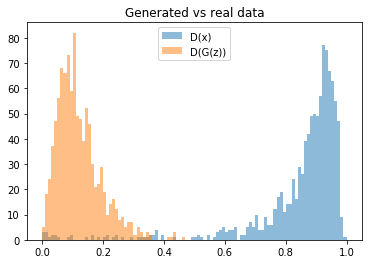

epoch 250


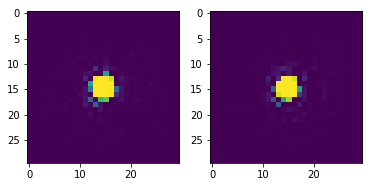

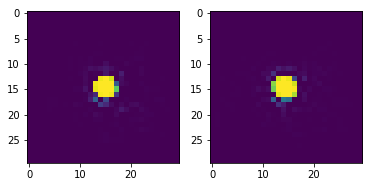

epoch 300


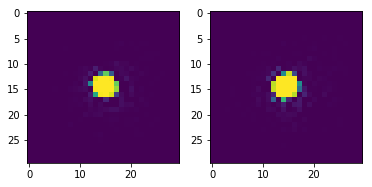

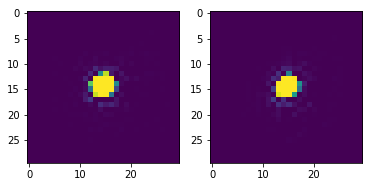

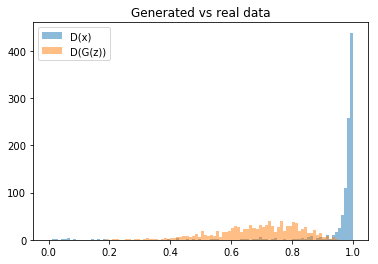

epoch 350


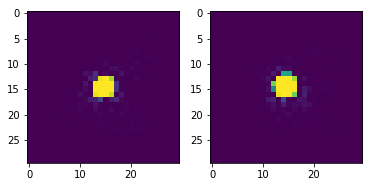

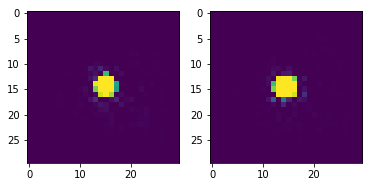

epoch 400


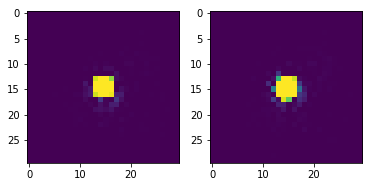

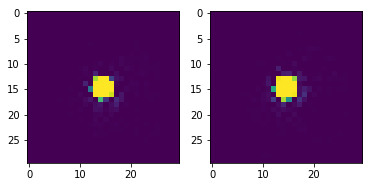

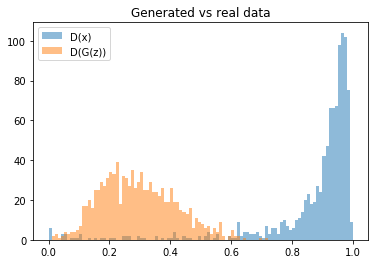

epoch 450


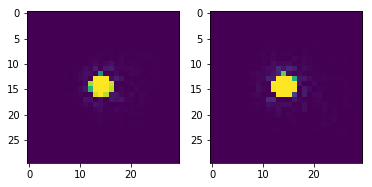

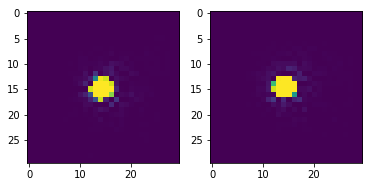

epoch 500


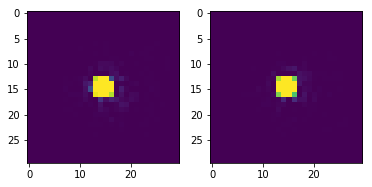

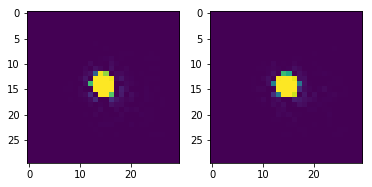

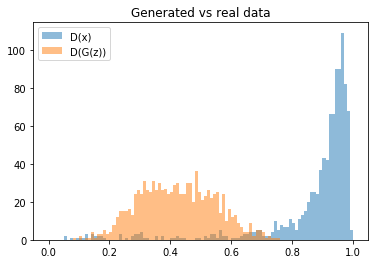

epoch 550


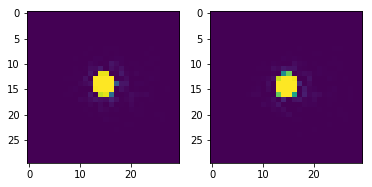

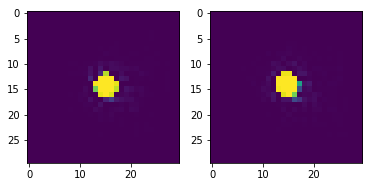

epoch 600


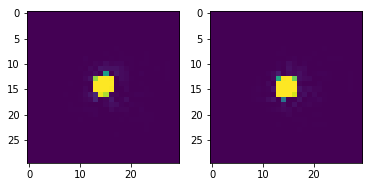

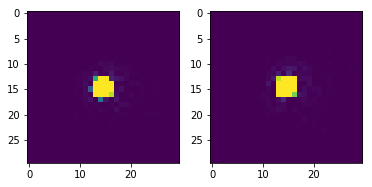

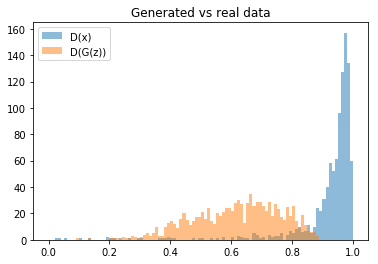

epoch 650


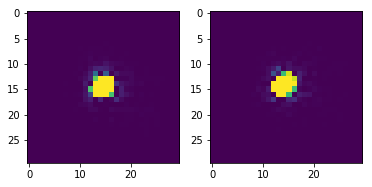

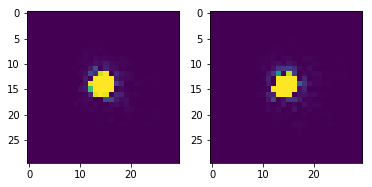

epoch 700


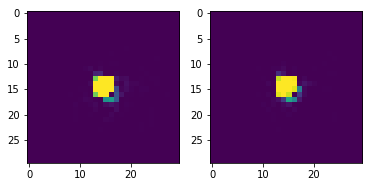

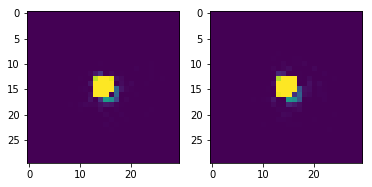

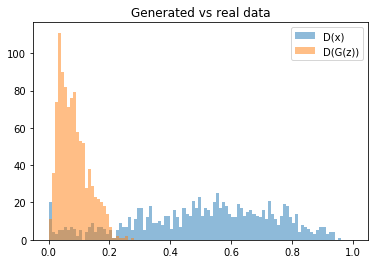

epoch 750


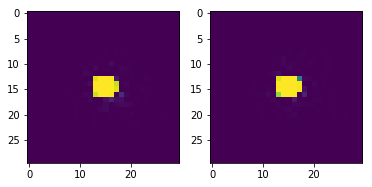

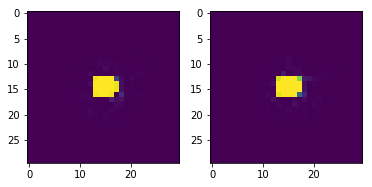

epoch 800


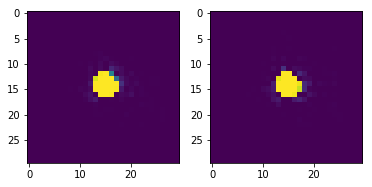

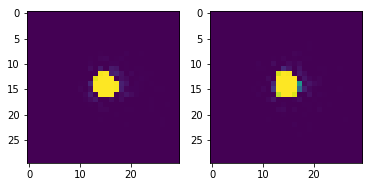

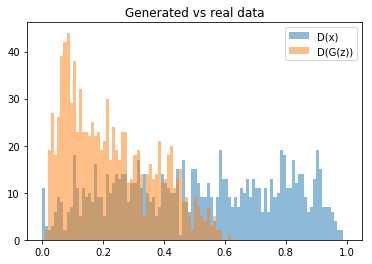

epoch 850


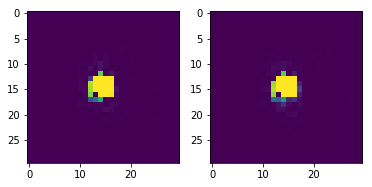

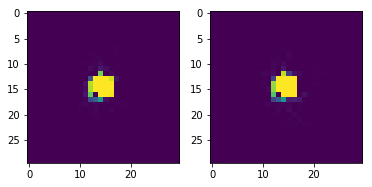

epoch 900


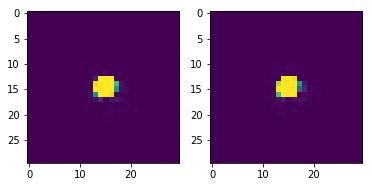

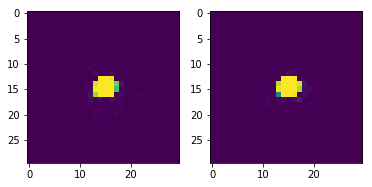

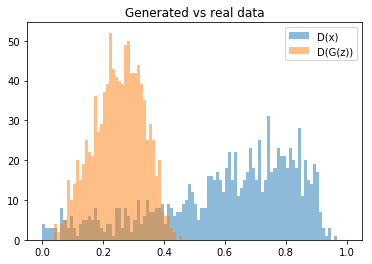

epoch 950


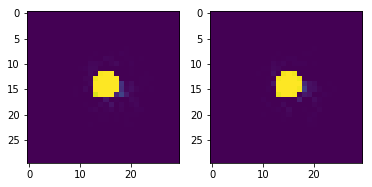

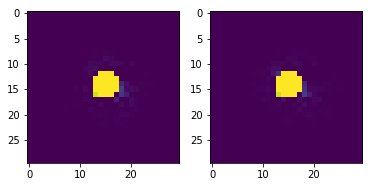

epoch 1000


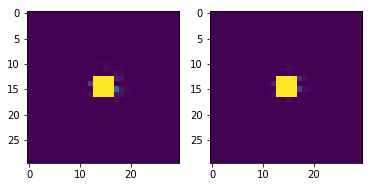

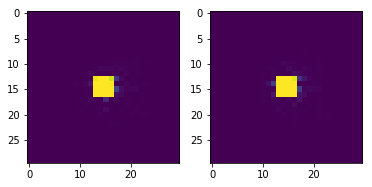

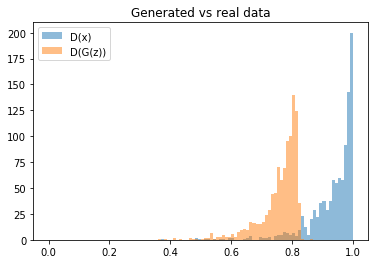

epoch 1050


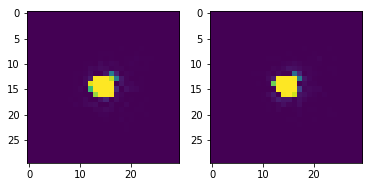

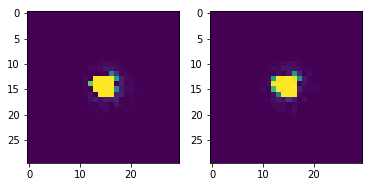

epoch 1100


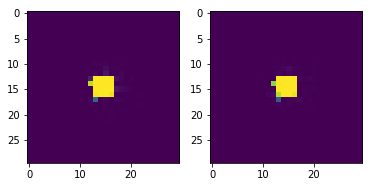

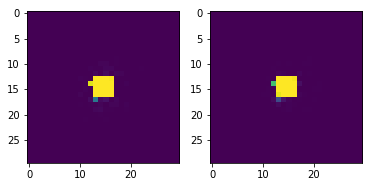

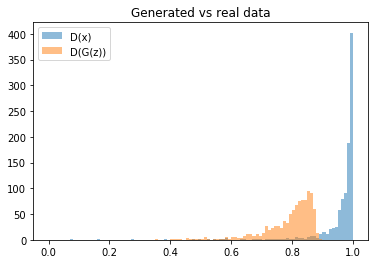

epoch 1150


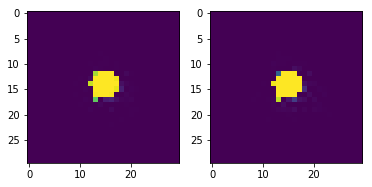

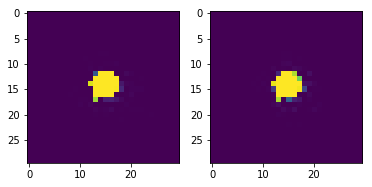

epoch 1200


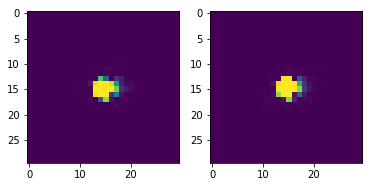

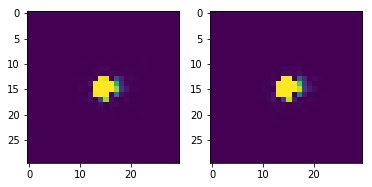

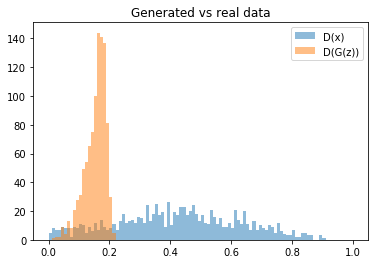

epoch 1250


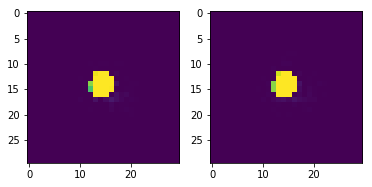

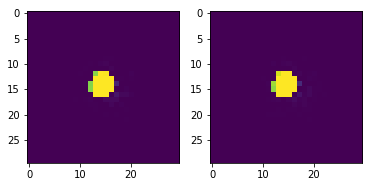

epoch 1300


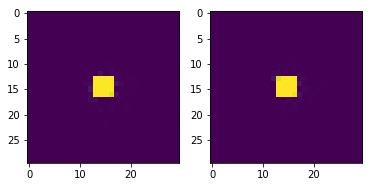

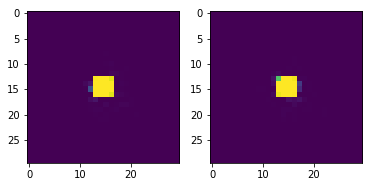

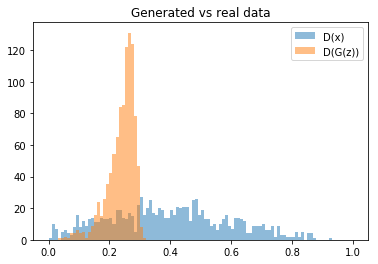

epoch 1350


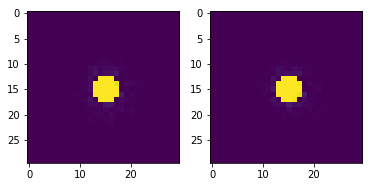

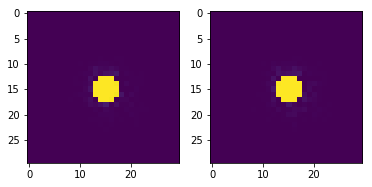

epoch 1400


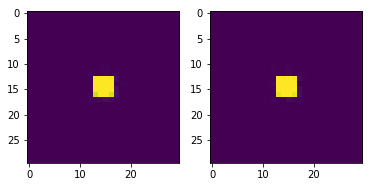

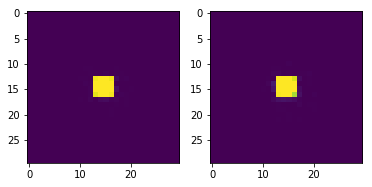

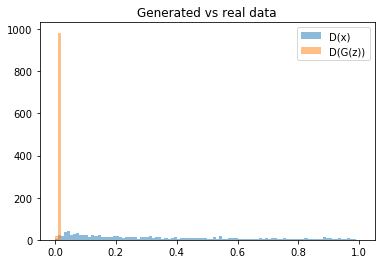

Generator lost the game around the epoch =  1400


In [83]:
k_disc = 2  # число обучений дискриминатора за эпоху
k_gen = 3  # число обучений генератора за эпоху
disc_learn_rate = 1e-4  # скорость обучения дискриминатора
gen_learn_rate = 1e-4  #скорость обучения генератора
epochs = 30000  # максимальное число эпох обучения
noise_size = 100
image_size = (30, 30, 1)
show_each = 50  # показывать каждую эпоху кратную ...
check_each = 100  # сравнивать работу дискриминатора на реальных и сгенерированных данных каждую эпоху кратную ...
disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise = \
                            build_gan(disc_learn_rate, gen_learn_rate, noise_size, image_size)
%matplotlib inline
generator_lost_on_epoch = play_the_game(k_disc, k_gen, disc, gen, \
                            disc_loss, gen_loss, train_disc, train_gen, real_img, noise, show_each, check_each, epochs)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


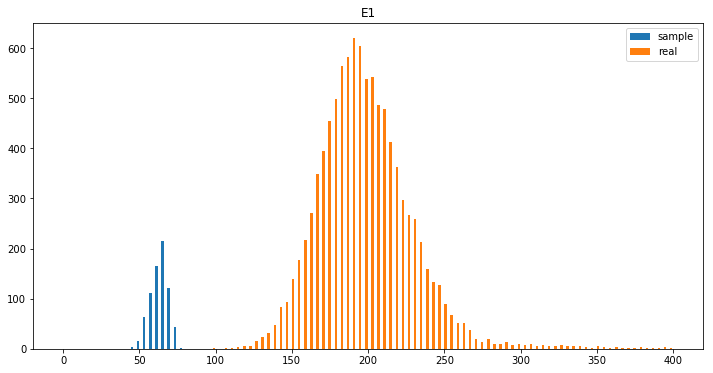

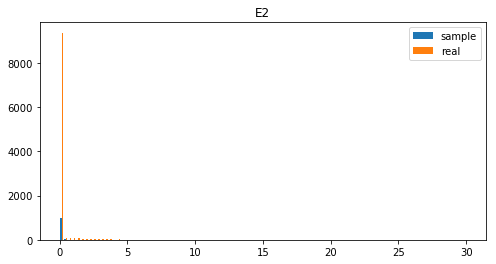

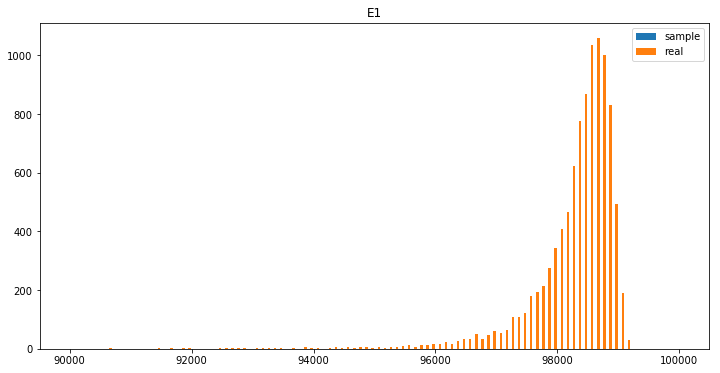

In [84]:
show_the_rezults()

epoch 0


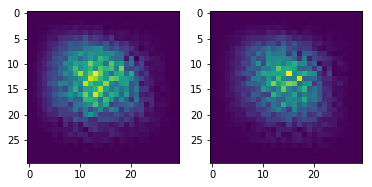

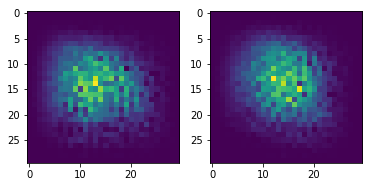

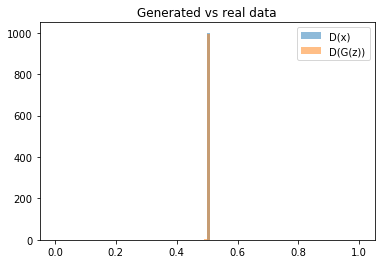

epoch 50


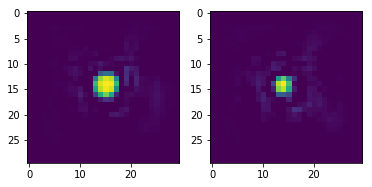

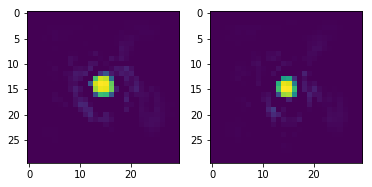

epoch 100


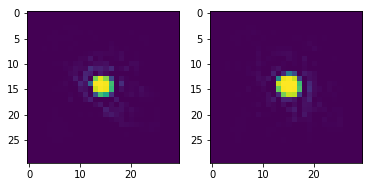

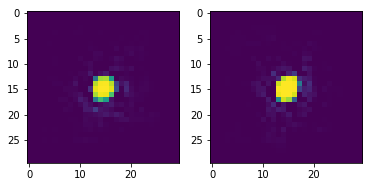

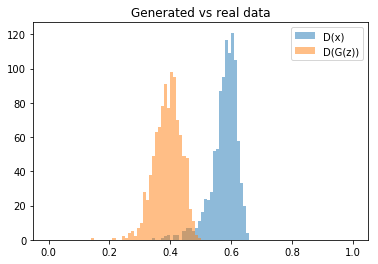

epoch 150


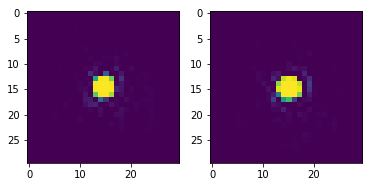

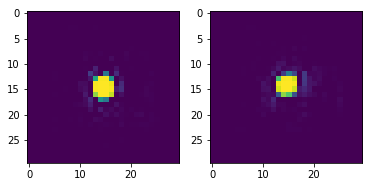

epoch 200


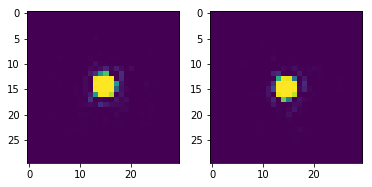

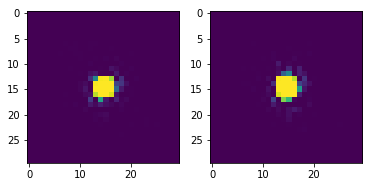

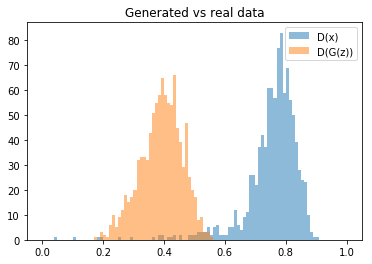

epoch 250


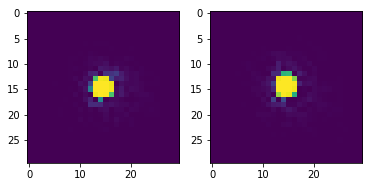

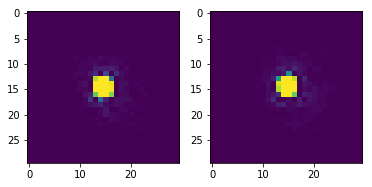

epoch 300


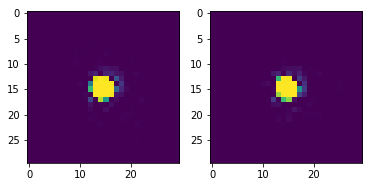

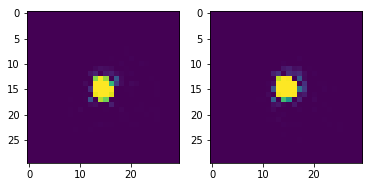

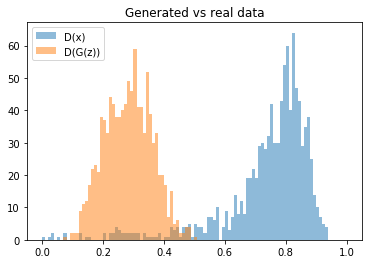

epoch 350


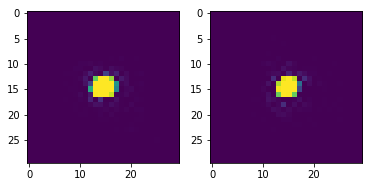

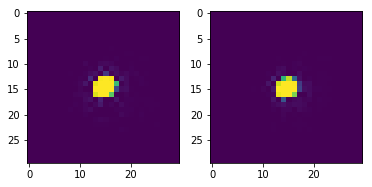

epoch 400


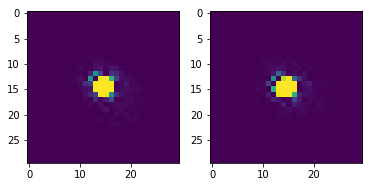

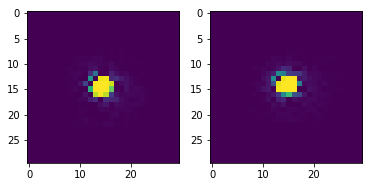

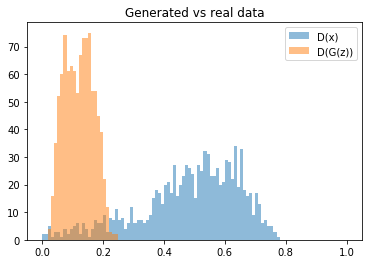

epoch 450


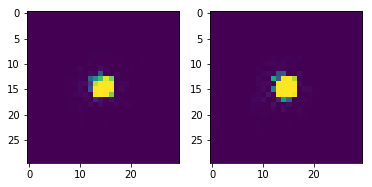

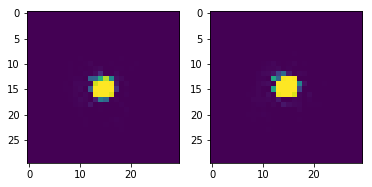

epoch 500


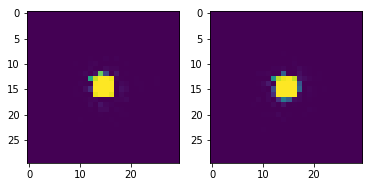

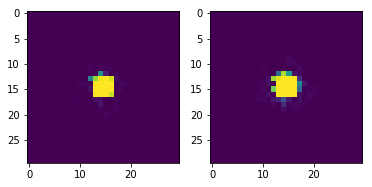

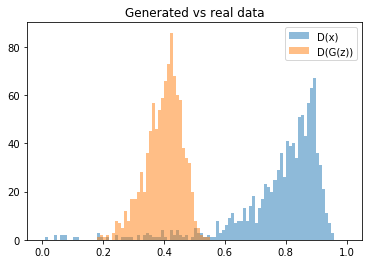

epoch 550


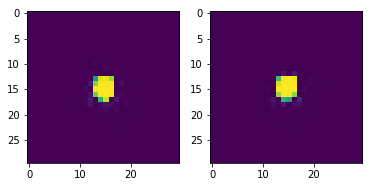

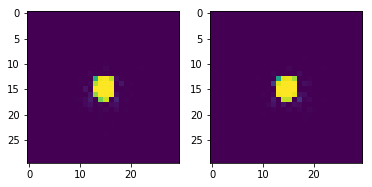

epoch 600


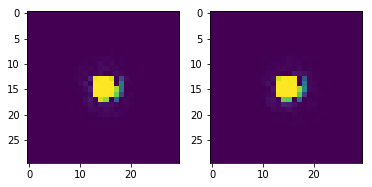

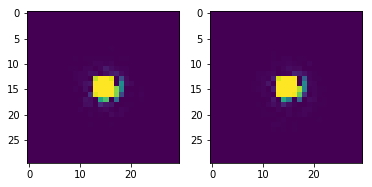

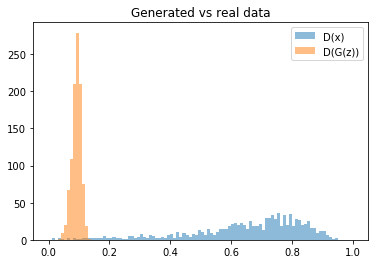

epoch 650


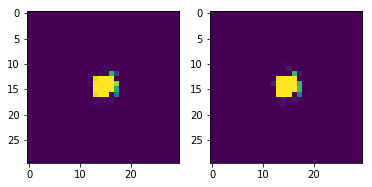

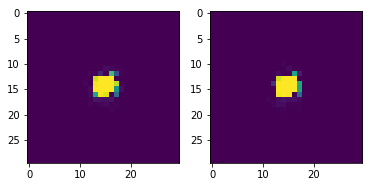

epoch 700


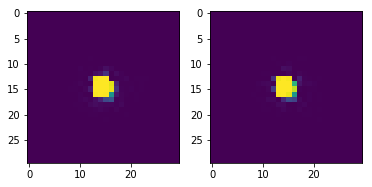

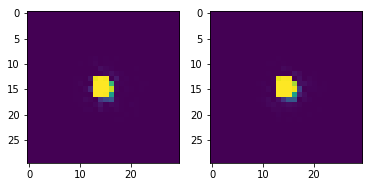

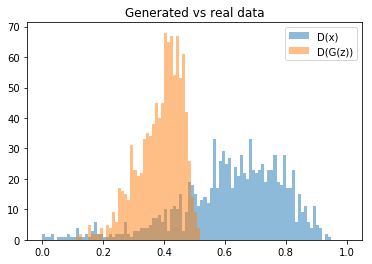

epoch 750


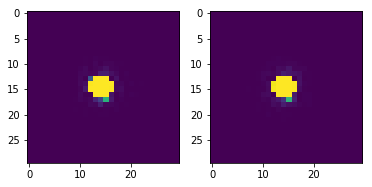

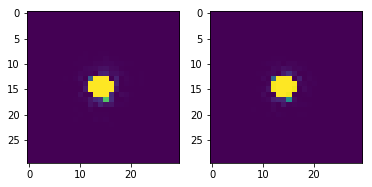

epoch 800


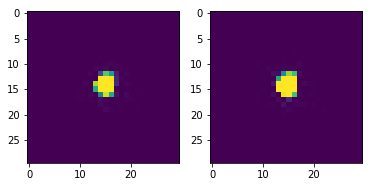

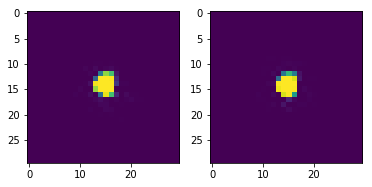

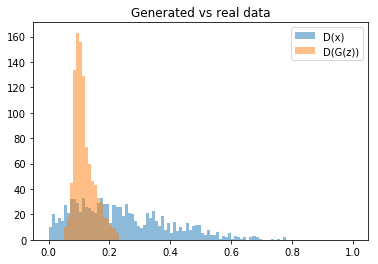

epoch 850


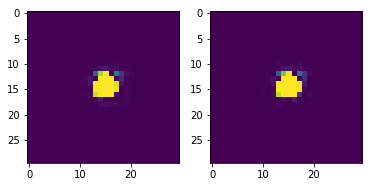

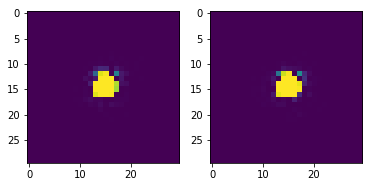

epoch 900


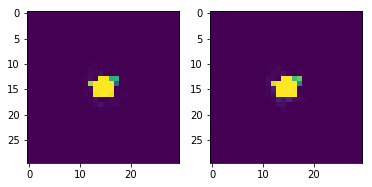

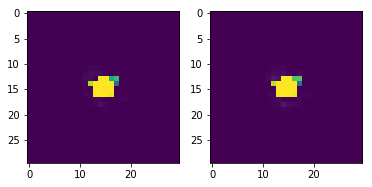

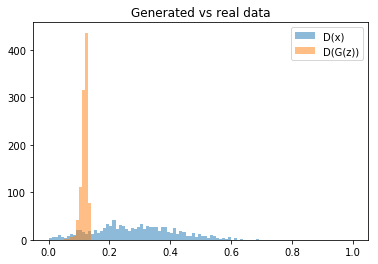

epoch 950


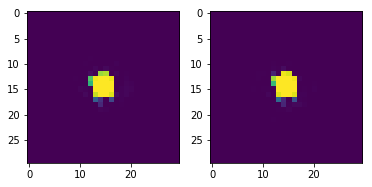

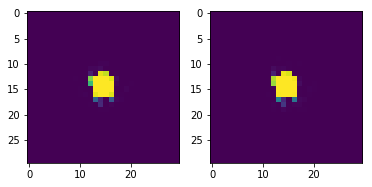

epoch 1000


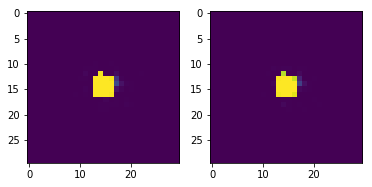

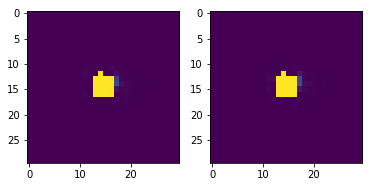

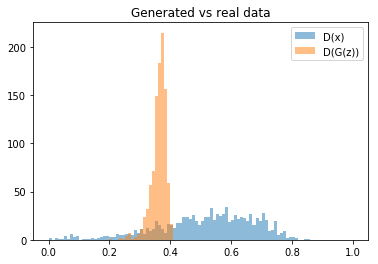

epoch 1050


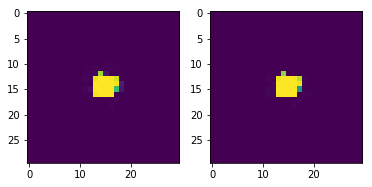

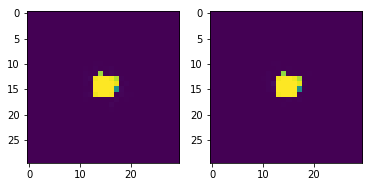

epoch 1100


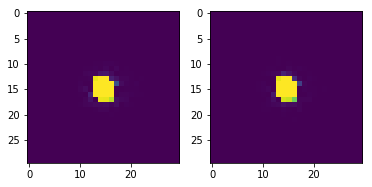

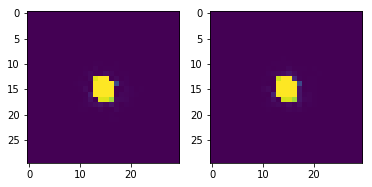

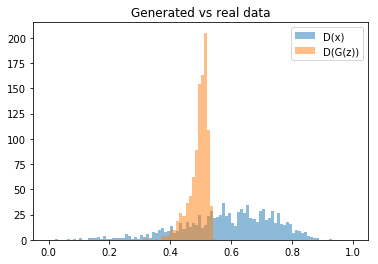

epoch 1150


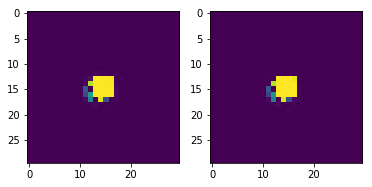

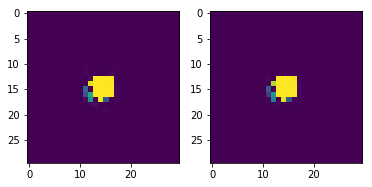

epoch 1200


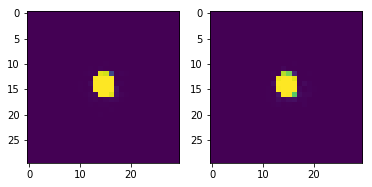

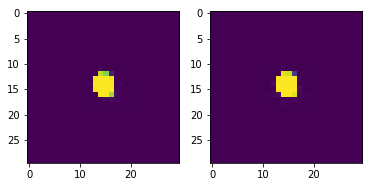

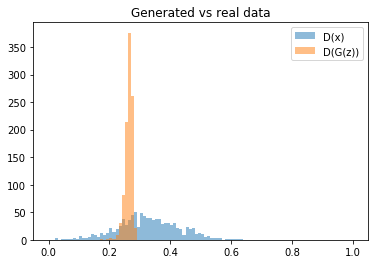

epoch 1250


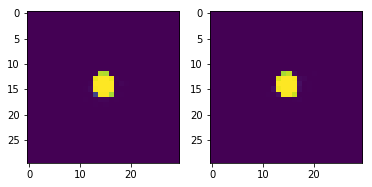

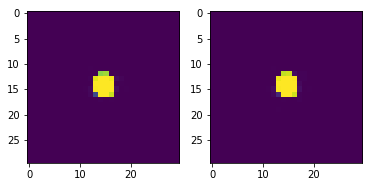

epoch 1300


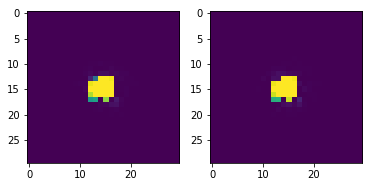

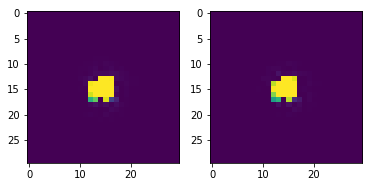

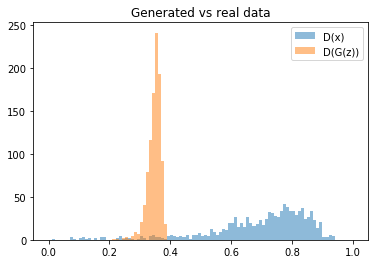

epoch 1350


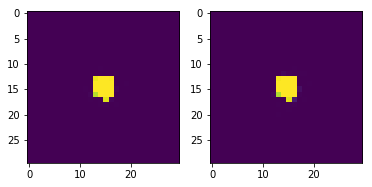

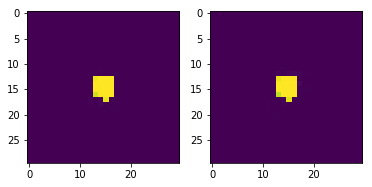

epoch 1400


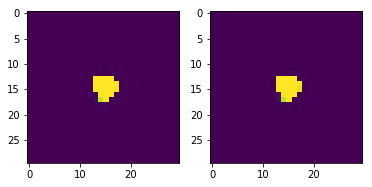

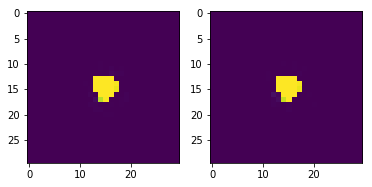

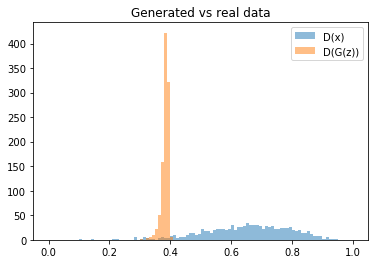

epoch 1450


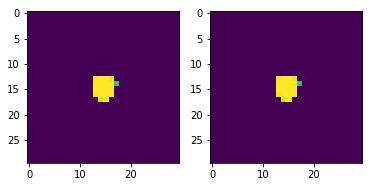

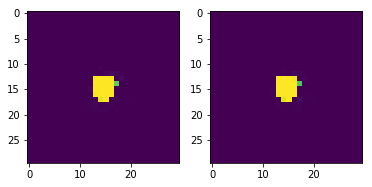

epoch 1500


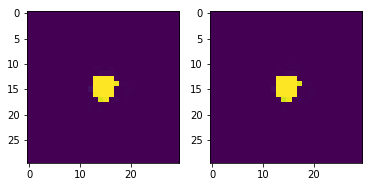

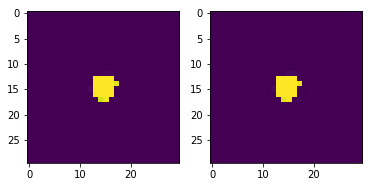

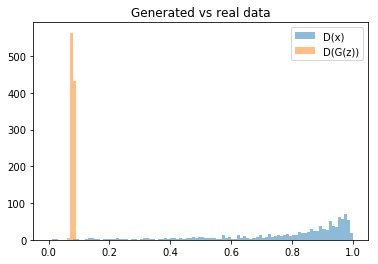

epoch 1550


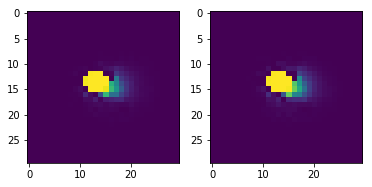

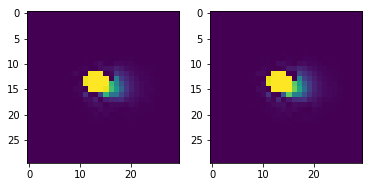

epoch 1600


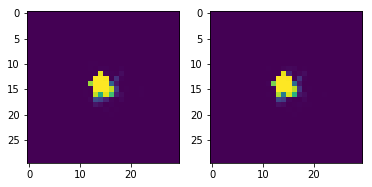

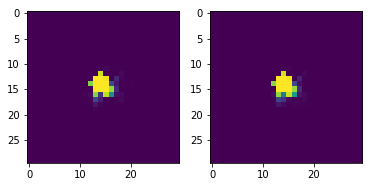

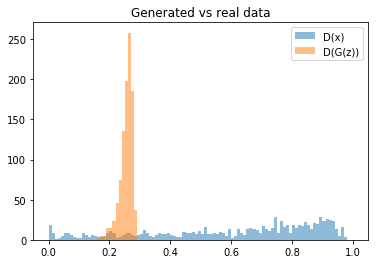

epoch 1650


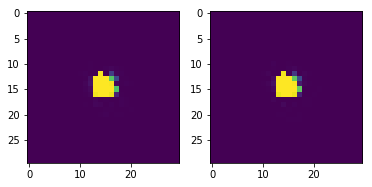

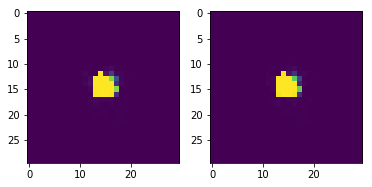

epoch 1700


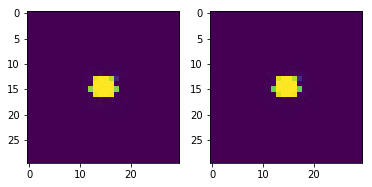

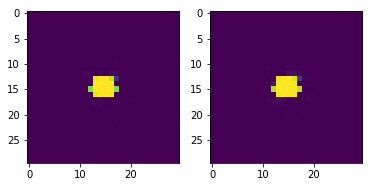

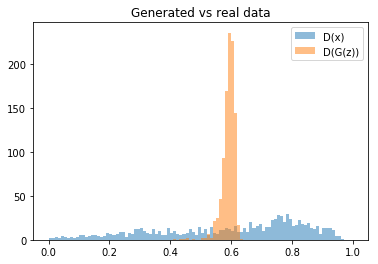

epoch 1750


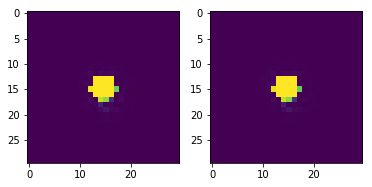

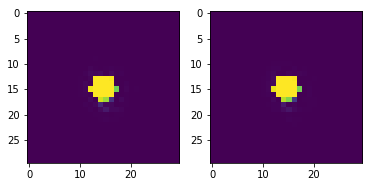

epoch 1800


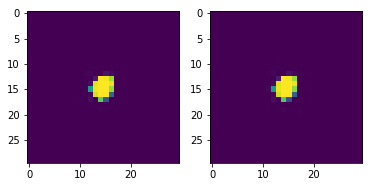

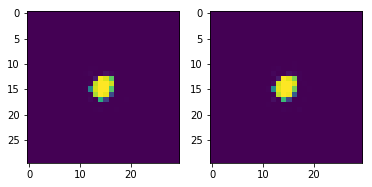

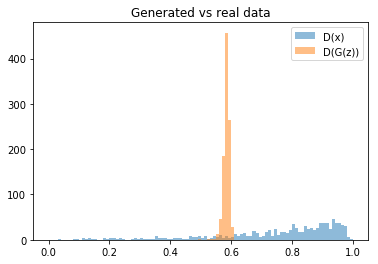

epoch 1850


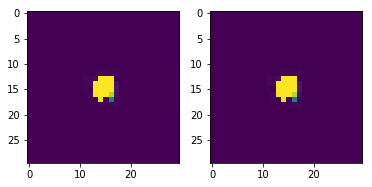

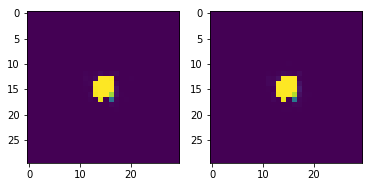

epoch 1900


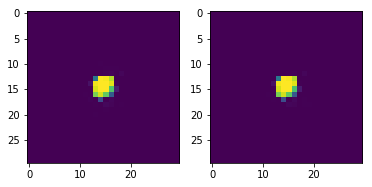

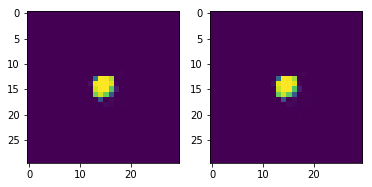

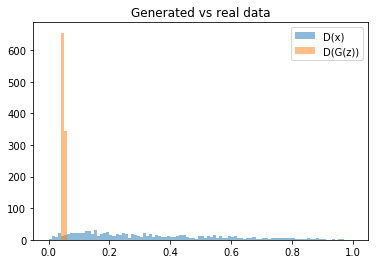

Generator lost the game around the epoch =  1900


In [85]:
k_disc = 1  # число обучений дискриминатора за эпоху
k_gen = 4  # число обучений генератора за эпоху
disc_learn_rate = 1e-4  # скорость обучения дискриминатора
gen_learn_rate = 1e-4  #скорость обучения генератора
epochs = 30000  # максимальное число эпох обучения
noise_size = 100
image_size = (30, 30, 1)
show_each = 50  # показывать каждую эпоху кратную ...
check_each = 100  # сравнивать работу дискриминатора на реальных и сгенерированных данных каждую эпоху кратную ...
disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise = \
                            build_gan(disc_learn_rate, gen_learn_rate, noise_size, image_size)
%matplotlib inline
generator_lost_on_epoch = play_the_game(k_disc, k_gen, disc, gen, \
                            disc_loss, gen_loss, train_disc, train_gen, real_img, noise, show_each, check_each, epochs)

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


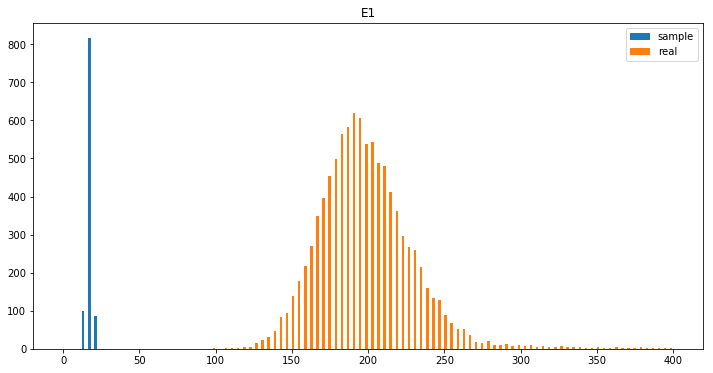

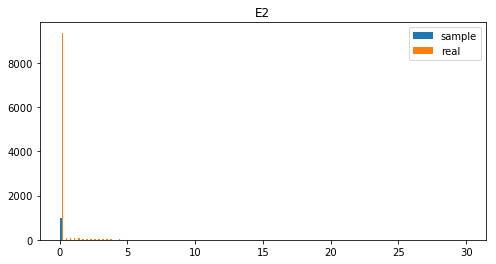

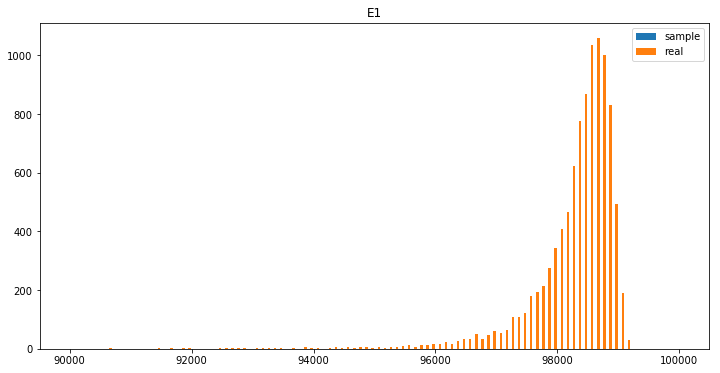

In [86]:
show_the_rezults()